# Reviving, reproducing and revisiting Axelrod's second tournament

In [1]:
import pathlib
import re

import axelrod as axl
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_selection import RFE, SequentialFeatureSelector, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import json

# Building the appendices

In [2]:
with open("./data/original_tournament/fortran_characteristics.json", "r") as f:
    characteristics = json.load(f)

In [3]:
second_tournament_strategies = [
    name for name in characteristics.keys()
    if characteristics[name]["original_rank"] is not None
]

with open("../assets/list_of_original_tournament_players.tex", "w") as f:
    for name in second_tournament_strategies:
        dictionary = characteristics[name]
        author=dictionary["author"]
        original_rank=dictionary["original_rank"]
        f.write(f"\\item {name} - Original rank: {original_rank}. Authored by {author}\n")

## Reproducing the original tournament

In [4]:
def get_turns(filename):
    """
    Read the number of turns if included in the file name
    """
    match = re.search("[0-9]+(?=(_turns))", str(filename))
    return int(match.group(0))

def get_repetitions(filename):
    """
    Read the number of repetitions if included in the file name
    """
    match = re.search("[0-9]+(?=(_repetitions))", str(filename))
    return int(match.group(0))

def read_tournament_repetitions(files, player_names=None):
    """
    Read the scores from a collection of gz files 
    representing repetitions of tournaments.
    """
    number_of_opponents = len(player_names) - 1
    dfs = []
    for gz_path in files:
        dfs.append(pd.read_csv(str(gz_path), header=None).iloc[:,0:number_of_opponents + 1])
        
        turns = get_turns(gz_path)
        
        dfs[-1] /= turns * (number_of_opponents)  # Scale all metrics
        dfs[-1].columns = player_names
        
    df = pd.concat(dfs, ignore_index=True)
    return df

In [5]:
original_tournament_data_path = pathlib.Path("./data/original_tournament/")
original_tournament_scores = read_tournament_repetitions(
                                   files=original_tournament_data_path.glob("*scores.gz"), 
                                   player_names=second_tournament_strategies)

In [6]:
original_tournament_scores.head()

k31r      k32r      k33r      k34r      k35r      k36r      k37r  \
0  2.729135  2.823349  2.024322  2.634409  2.790579  1.629544  2.693292   
1  2.727855  2.845366  2.014593  2.619048  2.795187  1.600614  2.691244   
2  2.743472  2.821045  2.035074  2.635177  2.822069  1.594470  2.696877   
3  2.734511  2.821045  2.034818  2.624168  2.815156  1.626472  2.698669   
4  2.742192  2.833077  2.031490  2.630824  2.826421  1.559396  2.692268   

       k38r      k39r      k40r  ...      k84r      k85r      k86r      k87r  \
0  2.688172  2.678955  2.746800  ...  2.830261  2.704045  2.748848  2.734255   
1  2.707117  2.732207  2.749872  ...  2.818484  2.726062  2.745008  2.693292   
2  2.682796  2.747824  2.738863  ...  2.833077  2.699693  2.751920  2.683308   
3  2.703533  2.678187  2.764977  ...  2.799283  2.710189  2.752176  2.703789   
4  2.695084  2.699181  2.709421  ...  2.815924  2.708653  2.739887  2.719150   

       k88r      k89r      k90r      k91r      k92r  krandomc  
0  2.760881  2.206093  2.716334  2.692268  2.869432  1.882744  
1  2.796979  2.199949  2.713518  2.716078  2.866359  1.845110  
2  2.795443  2.231183  2.718382  2.687660  2.866615  1.771633  
3  2.752944  2.198925  2.714030  2.723246  2.873016  1.960317  
4  2.762929  2.232207  2.700205  2.726318  2.861495  1.858679  

[5 rows x 63 columns]

In [7]:
def summarise_scores(scores, get_original=True):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)

    authors = []
    original_ranks = []
    for name in df.index:
        if name in characteristics:
            authors.append(characteristics[name]["author"])
            original_ranks.append(int(characteristics[name]["original_rank"]))
        else:
            authors.append(None)
            original_ranks.append(None)
    df["Author"] = authors
    df["Original rank"] = original_ranks

    return df

original_score_summary = summarise_scores(original_tournament_scores)

original_score_summary.head()

mean       std       min        5%       25%       50%       75%  \
k92r  2.873421  0.008500  2.825513  2.860524  2.866824  2.873553  2.879940   
k42r  2.863492  0.011319  2.807342  2.844913  2.856096  2.864238  2.872015   
k75r  2.832695  0.024357  2.720779  2.787652  2.817972  2.835777  2.849974   
k49r  2.825359  0.014380  2.751833  2.798594  2.817239  2.827029  2.835505   
k60r  2.820809  0.029735  2.703289  2.771208  2.800150  2.820872  2.845832   

           95%       max                        Author  Original rank  
k92r  2.886311  2.891234               Anatol Rapoport              1  
k42r  2.879556  2.892752                 Otto Borufsen              3  
k75r  2.867384  2.901131             Paul D Harrington              8  
k49r  2.845622  2.866359                      Rob Cave              4  
k60r  2.864055  2.890169  Jim Graaskamp and Ken Katzen              6

In [8]:
def violon_plot(scores, summary, filename):
    number_of_players = len(scores.columns)
    fig, ax = plt.subplots() 
    width = number_of_players / 3
    height = width / (1.5 * 1.414)
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 
    
    summary.sort_values("Original rank", inplace=True)

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xlabel("Strategy file name, ordered by original rank", fontsize=20)
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=40)
    
    
    fig.tight_layout()
    fig.savefig(filename, transparent=True);

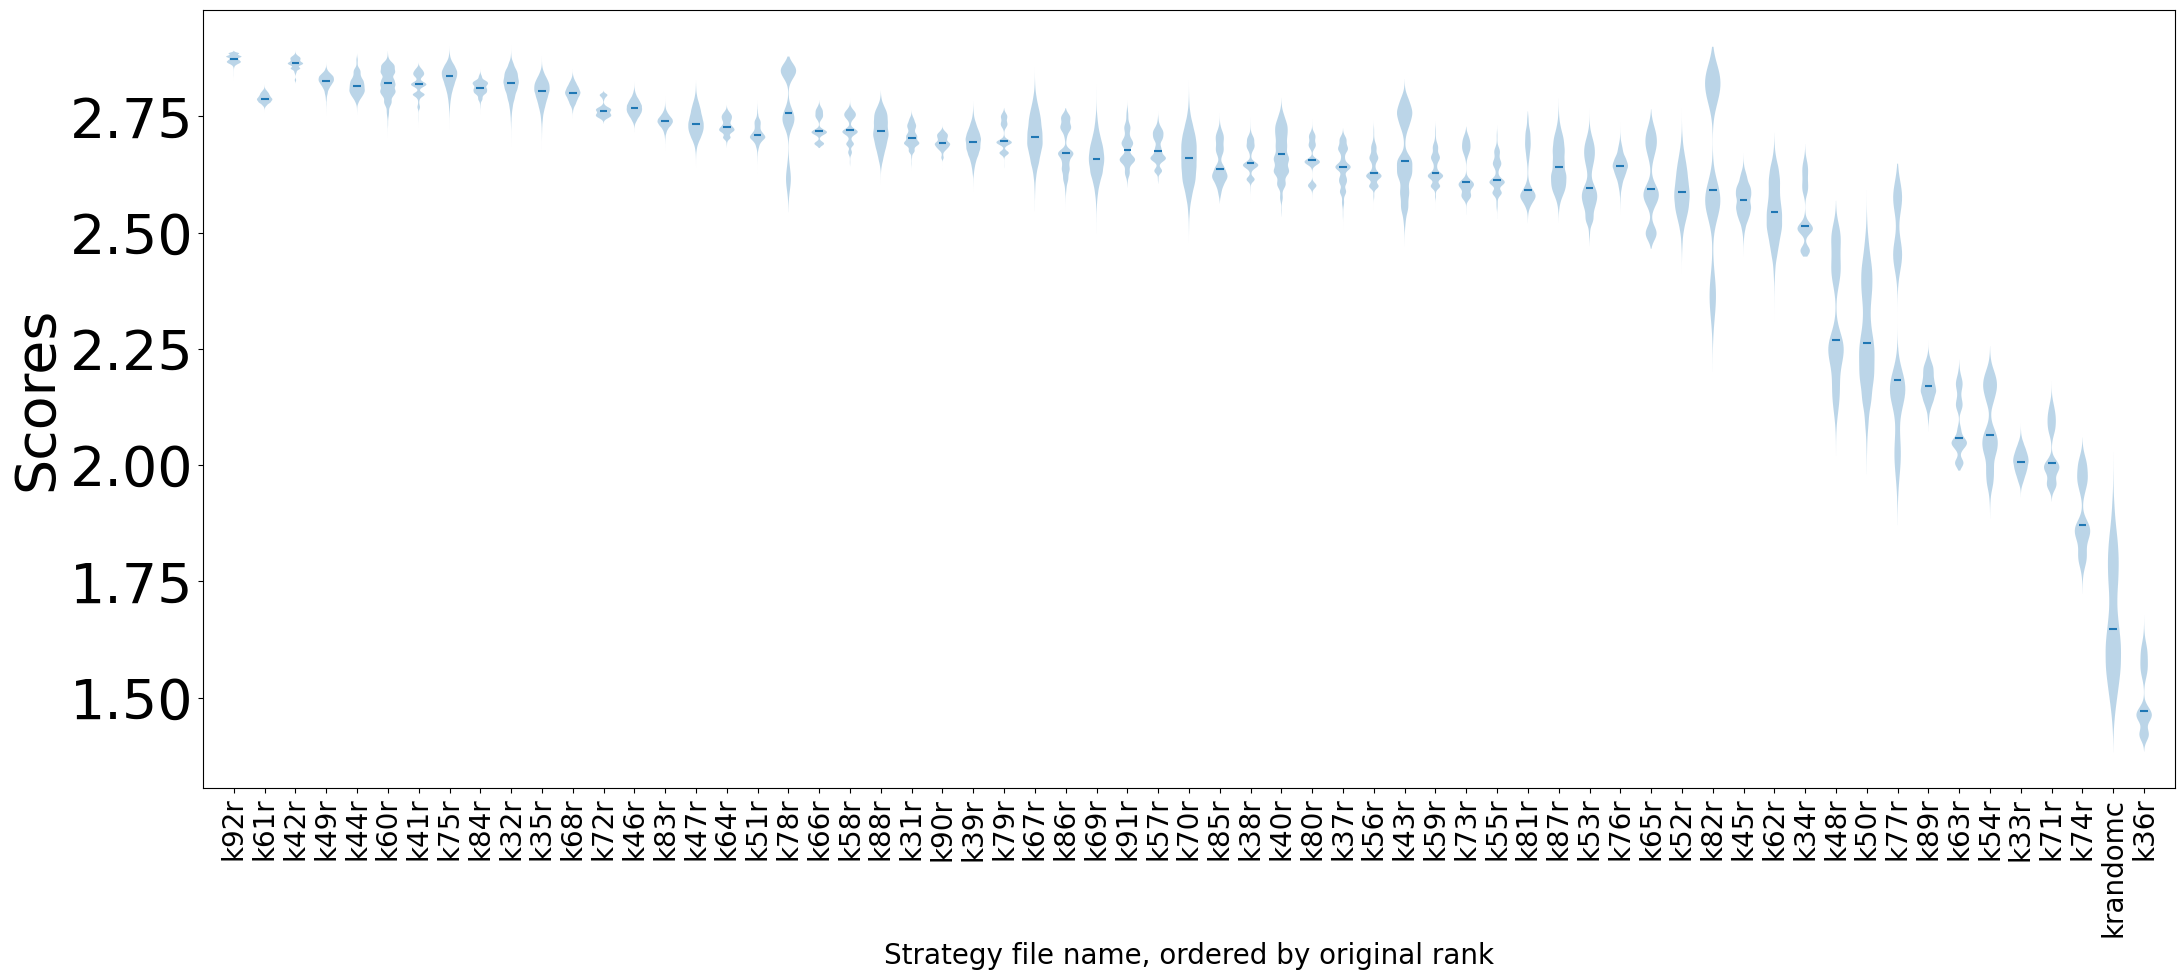

In [9]:
violon_plot(original_tournament_scores, original_score_summary, "../assets/original_scores_boxplots.pdf")
plt.ylabel("Scores", fontsize=40);

Let us consider the ranks over all repetitions of the tournaments (we have a lot of tournaments).

In [10]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)

    authors = []
    original_ranks = []
    for name in df.index:
        if name in characteristics:
            authors.append(characteristics[name]["author"])
            original_ranks.append(int(characteristics[name]["original_rank"]))
        else:
            authors.append(None)
            original_ranks.append(None)
    df["Author"] = authors
    df["Original rank"] = original_ranks
    
    return df

original_rank_summary = summarise_ranks(original_tournament_scores)

original_rank_summary.head(15)

mean        std  min    5%   25%   50%   75%   95%  max  \
k92r   1.50168   0.780744    1   1.0   1.0   1.0   2.0   3.0    8   
k42r   1.85866   0.744174    1   1.0   1.0   2.0   2.0   3.0    7   
k75r   5.40924   2.729821    1   2.0   3.0   5.0   7.0  11.0   17   
k49r   6.41728   2.477084    2   3.0   4.0   6.0   8.0  11.0   16   
k60r   6.95680   3.219902    1   3.0   4.0   6.0   9.0  13.0   19   
k32r   7.35866   3.410193    1   3.0   4.0   7.0  10.0  13.0   25   
k41r   7.37350   2.408697    2   4.0   6.0   7.0   9.0  12.0   16   
k44r   7.85574   3.863102    1   3.0   4.0   8.0  11.0  14.0   18   
k84r   8.54712   2.203981    2   5.0   7.0   9.0  10.0  12.0   18   
k35r   9.71078   3.302662    1   4.0   7.0  10.0  12.0  15.0   29   
k68r  10.02614   3.355798    2   4.0   8.0  10.0  13.0  15.0   23   
k61r  11.79348   1.570136    4   9.0  11.0  12.0  13.0  14.0   18   
k46r  14.47206   2.724083    4  11.0  13.0  14.0  16.0  19.5   32   
k78r  15.00998  10.992095    1   3.0   5.0  14.0  17.0  37.0   48   
k72r  15.60232   4.595343    4   9.0  13.0  14.0  19.0  24.0   32   

                                     Author  Original rank  
k92r                        Anatol Rapoport              1  
k42r                          Otto Borufsen              3  
k75r                      Paul D Harrington              8  
k49r                               Rob Cave              4  
k60r           Jim Graaskamp and Ken Katzen              6  
k32r                       Charles Kluepfel             10  
k41r                            Herb Weiner              7  
k44r                          William Adams              5  
k84r  T Nicolaus Tideman and Paula Chieruzz              9  
k35r                        Abraham Getzler             11  
k68r                       Fransois Leyvraz             12  
k61r                       Danny C Champion              2  
k46r                     Graham J Eatherley             14  
k78r                              Fred Mauk             19  
k72r                      Edward C White Jr             13

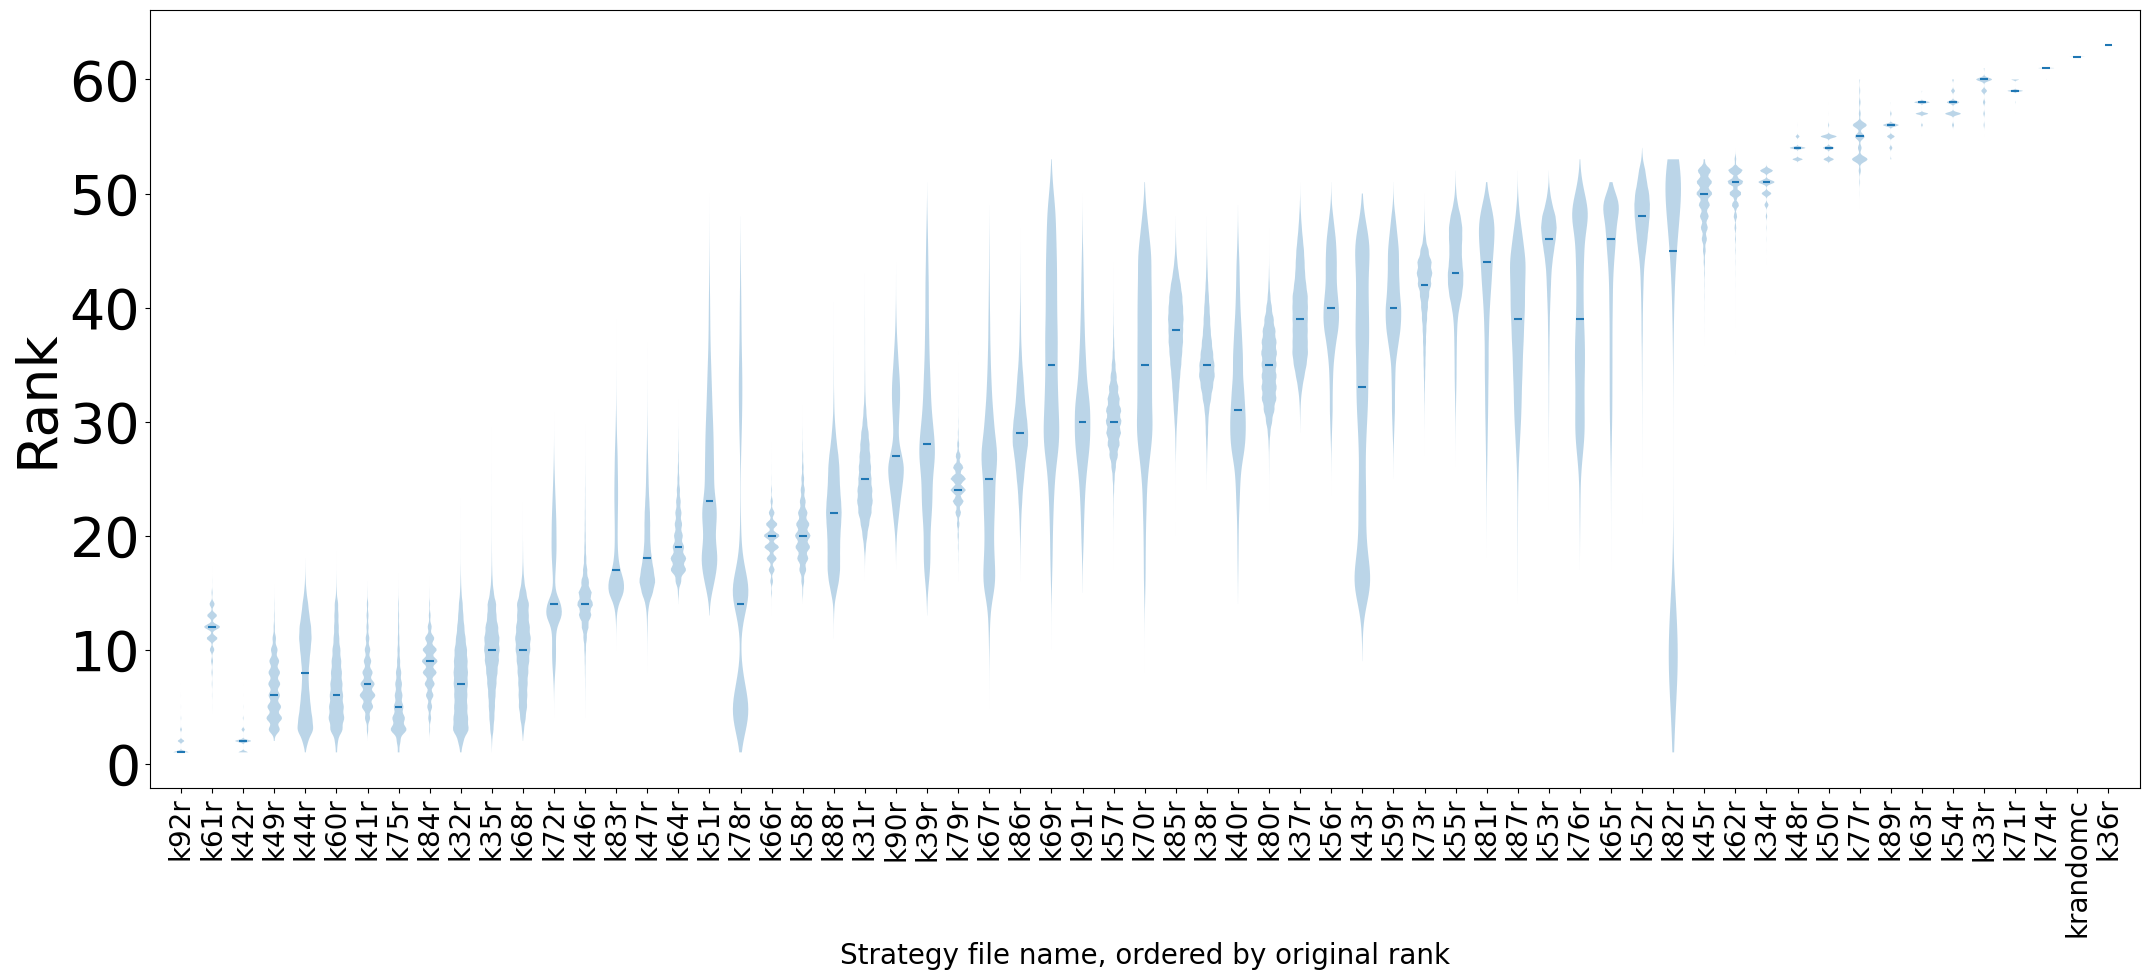

In [11]:
violon_plot(original_tournament_scores.rank(axis=1, ascending=False), 
            original_rank_summary, "../assets/original_ranks_boxplots.pdf")
plt.ylabel("Rank", fontsize=40);

Our scores (calculated above) ignore self interactions. Our payoffs do not:

In [12]:
def read_payoff_matrix(files):
    arrays = []
    turns = []
    repetitions = 0
    for gz_path in files:
        repetitions += get_repetitions(gz_path)
        arrays.append(np.array(pd.read_csv(str(gz_path), header=None)))  # Read through pd to deal with float conversion
        turns.append(get_turns(str(gz_path)))
    payoff_matrix = sum(array * turn for turn, array in zip(turns, arrays)) / sum(turns)

    return payoff_matrix, repetitions

In [13]:
original_tournament_payoff_matrix, original_repetitions = read_payoff_matrix(original_tournament_data_path.glob("*payoff_matrix.gz"))

Let us write the repetitions to file:

In [14]:
with open("../assets/number_of_original_repetitions.tex", "w") as f:
    f.write(f"{original_repetitions:,}")

Let us continue with the analysis of the scores:

In [15]:
scores = pd.DataFrame(original_tournament_payoff_matrix, 
                      second_tournament_strategies)
scores.columns = scores.index
scores

k31r      k32r      k33r      k34r      k35r      k36r  \
k31r      3.000000  3.000000  1.825166  3.000000  3.000000  1.355929   
k32r      3.000000  3.000000  2.266114  3.000000  3.000000  1.239309   
k33r      1.315232  1.273490  2.867550  0.986755  2.723067  1.262991   
k34r      3.000000  3.000000  1.284768  3.000000  3.000000  1.357888   
k35r      3.000000  3.000000  2.712783  3.000000  3.000000  1.252144   
...            ...       ...       ...       ...       ...       ...   
k89r      2.539073  2.659256  1.904636  0.980132  2.560372  1.150798   
k90r      3.000000  3.000000  1.580132  3.000000  3.000000  1.162890   
k91r      3.000000  3.000000  1.488742  3.000000  3.000000  1.211602   
k92r      3.000000  3.000000  2.900662  3.000000  3.000000  1.257422   
krandomc  2.360713  0.960745  1.050703  0.547155  2.270139  0.821423   

              k37r      k38r      k39r      k40r  ...      k84r      k85r  \
k31r      3.000000  3.000000  1.605298  3.000000  ...  3.000000  3.000000   
k32r      3.000000  3.000000  2.955243  3.000000  ...  3.000000  3.000000   
k33r      0.986755  1.315232  1.258278  1.204787  ...  1.468874  1.316556   
k34r      3.000000  3.000000  1.403974  3.000000  ...  3.000000  3.000000   
k35r      3.000000  3.000000  2.945975  3.000000  ...  3.000000  3.000000   
...            ...       ...       ...       ...  ...       ...       ...   
k89r      1.033113  1.033113  3.125828  1.113841  ...  2.033113  1.691391   
k90r      3.000000  3.000000  1.605298  3.000000  ...  3.000000  3.000000   
k91r      3.000000  3.000000  2.084768  3.000000  ...  3.000000  3.000000   
k92r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  3.000000   
krandomc  0.567035  0.829025  1.423339  1.148856  ...  0.641308  0.749496   

              k86r      k87r      k88r      k89r      k90r      k91r  \
k31r      3.000000  3.000000  3.000000  1.704636  3.000000  3.000000   
k32r      3.000000  3.000000  3.000000  2.587502  3.000000  3.000000   
k33r      1.006623  1.840296  2.059480  1.613245  3.891391  2.058278   
k34r      3.000000  3.000000  3.000000  1.841060  3.000000  3.000000   
k35r      3.000000  3.000000  3.000000  2.546348  3.000000  3.000000   
...            ...       ...       ...       ...       ...       ...   
k89r      1.491391  1.749894  2.352756  2.613245  3.152318  3.492715   
k90r      3.000000  3.000000  3.000000  2.490066  3.000000  3.000000   
k91r      3.000000  3.000000  3.000000  1.426490  3.000000  3.000000   
k92r      3.000000  3.000000  3.000000  2.635762  3.000000  3.000000   
krandomc  0.974552  1.270627  2.348461  1.822680  3.136656  1.547000   

              k92r  krandomc  
k31r      3.000000  2.202516  
k32r      3.000000  2.802069  
k33r      2.900662  2.765306  
k34r      3.000000  2.979328  
k35r      3.000000  2.240069  
...            ...       ...  
k89r      2.649007  2.432150  
k90r      3.000000  1.871283  
k91r      3.000000  2.553775  
k92r      3.000000  2.247304  
krandomc  2.263748  2.248527  

[63 rows x 63 columns]

In [16]:
scores["Scores"] = np.mean(original_tournament_payoff_matrix, axis=1)
scores["Rank"] = scores["Scores"].rank(ascending=False).astype(int)
scores["Original Rank"] =  [characteristics[name]["original_rank"] for name in scores.index]
scores["Author"] =  [characteristics[name]["author"] for name in scores.index]
scores.sort_values("Original Rank", inplace=True)

In [17]:
scores.head()

k31r  k32r      k33r  k34r  k35r      k36r  k37r  k38r      k39r  k40r  \
k92r   3.0   3.0  2.900662   3.0   3.0  1.257422   3.0   3.0  2.993377   3.0   
k61r   3.0   3.0  2.854305   3.0   3.0  1.112628   3.0   3.0  2.993377   3.0   
k42r   3.0   3.0  2.137748   3.0   3.0  1.199216   3.0   3.0  2.993377   3.0   
k49r   3.0   3.0  2.279602   3.0   3.0  1.286362   3.0   3.0  2.904710   3.0   
k44r   3.0   3.0  2.360991   3.0   3.0  1.227057   3.0   3.0  2.791589   3.0   

      ...  k88r      k89r  k90r  k91r  k92r  krandomc    Scores  Rank  \
k92r  ...   3.0  2.635762   3.0   3.0   3.0  2.247304  2.878471     1   
k61r  ...   3.0  2.530366   3.0   3.0   3.0  1.875764  2.790747    12   
k42r  ...   3.0  2.621192   3.0   3.0   3.0  2.798713  2.860687     2   
k49r  ...   3.0  2.364432   3.0   3.0   3.0  2.694843  2.825954     4   
k44r  ...   3.0  2.446443   3.0   3.0   3.0  2.204224  2.825962     3   

      Original Rank            Author  
k92r              1   Anatol Rapoport  
k61r              2  Danny C Champion  
k42r              3     Otto Borufsen  
k49r              4          Rob Cave  
k44r              5     William Adams  

[5 rows x 67 columns]

There are a few other variants of the tournament:

- An alternative `k47` (two were in the original source code)
- A python implementation of the strategy by Champion (this seems to be the strategy with the biggest performance discrepancy)
- Using all python implementations of the original tournament

In [18]:
original_tournament_with_alt_k74r_data_path = pathlib.Path("./data/original_with_alt_k74r_tournament/")
original_tournament_with_alt_k74r_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_alt_k74r_data_path.glob("*payoff_matrix.gz"))
original_tournament_with_alt_k74r_index = pd.read_csv(
    "./data/original_with_alt_k74r_tournament/players.index",
    names=("Name",),
)

In [19]:
alt_k74r_scores = pd.DataFrame(original_tournament_with_alt_k74r_payoff_matrix, 
                      original_tournament_with_alt_k74r_index["Name"])
alt_k74r_scores.columns = alt_k74r_scores.index
alt_k74r_scores["Scores"] = np.mean(original_tournament_with_alt_k74r_payoff_matrix, axis=1)
alt_k74r_scores["Rank"] = alt_k74r_scores["Scores"].rank(ascending=False).astype(int)
alt_k74r_scores["Original Rank"] =  [characteristics[name]["original_rank"] for name in alt_k74r_scores.index]
alt_k74r_scores["Author"] =  [characteristics[name]["author"] for name in alt_k74r_scores.index]
alt_k74r_scores.sort_values("Original Rank", inplace=True)
alt_k74r_scores

Name          k31r      k32r      k33r      k34r      k35r      k36r  \
Name                                                                   
k92r      3.000000  3.000000  2.900662  3.000000  3.000000  1.257422   
k61r      3.000000  3.000000  2.854305  3.000000  3.000000  1.112628   
k42r      3.000000  3.000000  2.137748  3.000000  3.000000  1.199216   
k49r      3.000000  3.000000  2.279602  3.000000  3.000000  1.286362   
k44r      3.000000  3.000000  2.360991  3.000000  3.000000  1.227057   
...            ...       ...       ...       ...       ...       ...   
k33r      1.315232  1.273490  2.867550  0.986755  2.723067  1.262991   
k71r      3.996026  1.095208  3.830464  1.033113  1.104713  1.300448   
krandomc  2.360713  0.960745  1.050703  0.547155  2.270139  0.821423   
k36r      0.944917  1.356604  1.275984  0.937150  1.314867  1.265262   
k74rxx    1.026490  1.104157  0.589404  1.026490  1.377785  1.246261   

Name          k37r      k38r      k39r      k40r  ...      k88r      k89r  \
Name                                              ...                       
k92r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  2.635762   
k61r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  2.530366   
k42r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  2.621192   
k49r      3.000000  3.000000  2.904710  3.000000  ...  3.000000  2.364432   
k44r      3.000000  3.000000  2.791589  3.000000  ...  3.000000  2.446443   
...            ...       ...       ...       ...  ...       ...       ...   
k33r      0.986755  1.315232  1.258278  1.204787  ...  2.059480  1.613245   
k71r      1.033113  3.996026  3.825166  1.064943  ...  1.343227  2.770861   
krandomc  0.567035  0.829025  1.423339  1.148856  ...  2.348461  1.822680   
k36r      0.936958  1.004248  1.496593  1.082336  ...  1.496373  1.671715   
k74rxx    1.026490  0.119205  1.241060  0.087102  ...  1.852278  1.054305   

Name          k90r      k91r      k92r  krandomc    Scores  Rank  \
Name                                                               
k92r      3.000000  3.000000  3.000000  2.247304  2.854714     1   
k61r      3.000000  3.000000  3.000000  1.875764  2.779994    12   
k42r      3.000000  3.000000  3.000000  2.798713  2.841513     3   
k49r      3.000000  3.000000  3.000000  2.694843  2.843891     2   
k44r      3.000000  3.000000  3.000000  2.204224  2.820540     4   
...            ...       ...       ...       ...       ...   ...   
k33r      3.891391  2.058278  2.900662  2.765306  2.061609    58   
k71r      3.996026  2.773510  1.059603  2.609430  1.962099    60   
krandomc  3.136656  1.547000  2.263748  2.248527  1.623870    61   
k36r      1.632318  1.458383  1.288632  2.861525  1.470282    62   
k74rxx    1.470199  5.000000  1.026490  2.895388  1.351893    63   

Name      Original Rank            Author  
Name                                       
k92r                1.0   Anatol Rapoport  
k61r                2.0  Danny C Champion  
k42r                3.0     Otto Borufsen  
k49r                4.0          Rob Cave  
k44r                5.0     William Adams  
...                 ...               ...  
k33r               59.0     Harold Rabbie  
k71r               60.0      James E Hall  
krandomc           62.0              None  
k36r               63.0        Roger Hotz  
k74rxx              NaN  Edward Friedland  

[63 rows x 67 columns]

In [20]:
fortran_strategies = [s for s in second_tournament_strategies 
                      if characteristics[s]["axelrod-python_class"] is None]
assert len(fortran_strategies) == 38, f"Number of Fortran strategies={len(fortran_strategies)}"

In [21]:
fortran_strategies = [s for s in second_tournament_strategies 
                      if characteristics[s]["axelrod-python_class"] is None]
python_strategies = [s for s in second_tournament_strategies 
                     if characteristics[s]["axelrod-python_class"] is not None]

original_tournament_with_all_py_data_path = pathlib.Path("./data/original_tournament_with_python_implementations/")
original_tournament_with_all_py_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_all_py_data_path .glob("*payoff_matrix.gz"))

In [22]:
player_names = fortran_strategies + python_strategies
py_scores = pd.DataFrame(original_tournament_with_all_py_payoff_matrix, 
                         player_names, 
                         columns=player_names)
py_scores["Scores"] = np.mean(original_tournament_with_all_py_payoff_matrix, axis=1)
py_scores["Rank"] = py_scores["Scores"].rank(ascending=False).astype(int)
py_scores["Original Rank"] =  [characteristics[name]["original_rank"] for name in py_scores.index]
py_scores["Author"] =  [characteristics[name]["author"] for name in py_scores.index]
py_scores.sort_values("Original Rank", inplace=True)
py_scores

k33r      k36r      k37r      k38r      k39r      k40r  \
k92r      2.900662  1.259403  3.000000  3.000000  2.993377  3.000000   
k61r      2.854305  1.113094  3.000000  3.000000  2.993377  3.000000   
k42r      2.137748  1.200790  3.000000  3.000000  2.993377  3.000000   
k49r      2.282295  1.283781  3.000000  3.000000  2.907379  3.000000   
k44r      2.361863  1.203733  3.000000  3.000000  2.791834  3.000000   
...            ...       ...       ...       ...       ...       ...   
k33r      2.867550  1.263450  0.986755  1.315232  1.258278  1.204446   
k71r      3.830464  1.300995  1.033113  3.996026  3.825166  1.065122   
k74r      1.304636  1.356153  1.019868  1.099338  1.585430  1.060760   
krandomc  1.055618  0.820377  0.567085  0.826649  1.423580  1.147213   
k36r      1.276538  1.265459  0.937122  1.003582  1.500256  1.081923   

              k43r      k45r      k46r      k48r  ...      k83r      k84r  \
k92r      2.993377  2.993377  3.000000  2.993377  ...  3.000000  3.000000   
k61r      2.993377  2.645033  3.000000  2.960265  ...  3.000000  3.000000   
k42r      2.993377  2.993377  3.000000  2.993377  ...  3.000000  3.000000   
k49r      2.930002  2.883492  3.000000  2.730545  ...  3.000000  3.000000   
k44r      2.890177  2.427991  3.000000  2.091951  ...  3.000000  3.000000   
...            ...       ...       ...       ...  ...       ...       ...   
k33r      1.083444  3.389404  3.147394  1.189404  ...  3.107588  1.468874   
k71r      1.238411  1.278146  2.346320  1.772185  ...  2.073489  2.153642   
k74r      1.218543  2.490066  3.126184  1.292715  ...  2.056699  1.656954   
krandomc  0.791913  2.622208  3.100197  1.627337  ...  3.118427  0.638291   
k36r      1.218243  1.322190  1.608312  1.338090  ...  1.783113  1.877074   

              k86r      k90r      k92r  krandomc    Scores  Rank  \
k92r      3.000000  3.000000  3.000000  2.242220  2.878475     1   
k61r      3.000000  3.000000  3.000000  1.878004  2.790764    12   
k42r      3.000000  3.000000  3.000000  2.794450  2.860572     2   
k49r      3.000000  3.000000  3.000000  2.698585  2.824885     5   
k44r      3.000000  3.000000  3.000000  2.201888  2.826362     3   
...            ...       ...       ...       ...       ...   ...   
k33r      1.006623  3.891391  2.900662  2.762901  2.015003    59   
k71r      1.059603  3.996026  1.059603  2.611283  1.983032    60   
k74r      1.059603  3.390728  2.509934  2.960549  1.843530    61   
krandomc  0.978309  3.135394  2.258889  2.251642  1.619768    62   
k36r      0.972938  1.630243  1.290447  2.863096  1.465392    63   

          Original Rank            Author  
k92r                  1   Anatol Rapoport  
k61r                  2  Danny C Champion  
k42r                  3     Otto Borufsen  
k49r                  4          Rob Cave  
k44r                  5     William Adams  
...                 ...               ...  
k33r                 59     Harold Rabbie  
k71r                 60      James E Hall  
k74r                 61  Edward Friedland  
krandomc             62              None  
k36r                 63        Roger Hotz  

[63 rows x 67 columns]

In [23]:
original_tournament_with_py_ch_data_path = pathlib.Path("./data/original_tournament_with_python_champion/")
original_tournament_with_py_ch_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_py_ch_data_path.glob("*payoff_matrix.gz"))
original_tournament_with_py_ch_index = pd.read_csv(
    "./data/original_tournament_with_python_champion/players.index",
    names=("Name",),
)

In [24]:
py_ch_scores = pd.DataFrame(original_tournament_with_py_ch_payoff_matrix, 
                      original_tournament_with_py_ch_index["Name"])
py_ch_scores.columns = py_ch_scores.index
py_ch_scores["Scores"] = np.mean(original_tournament_with_py_ch_payoff_matrix, axis=1)
py_ch_scores["Rank"] = py_ch_scores["Scores"].rank(ascending=False).astype(int)
original_names = list(py_ch_scores.index)[:-1] + ["k61r"]
py_ch_scores["Original Rank"] =  [characteristics[name]["original_rank"] for name in original_names]
py_ch_scores["Author"] =  [characteristics[name]["author"] for name in original_names]
py_ch_scores.sort_values("Original Rank", inplace=True)
py_ch_scores

Name                    k31r      k32r      k33r      k34r      k35r  \
Name                                                                   
k92r                3.000000  3.000000  2.900662  3.000000  3.000000   
Second by Champion  3.000000  3.000000  2.854305  3.000000  3.000000   
k42r                3.000000  3.000000  2.137748  3.000000  3.000000   
k49r                3.000000  3.000000  2.279602  3.000000  3.000000   
k44r                3.000000  3.000000  2.360991  3.000000  3.000000   
...                      ...       ...       ...       ...       ...   
k33r                1.315232  1.273490  2.867550  0.986755  2.723067   
k71r                3.996026  1.094913  3.830464  1.033113  1.105651   
k74r                2.509934  1.757329  1.304636  1.019868  1.566409   
krandomc            2.346169  0.955959  1.049196  0.547631  2.269189   
k36r                0.944917  1.356604  1.275984  0.937150  1.314867   

Name                    k36r      k37r      k38r      k39r      k40r  ...  \
Name                                                                  ...   
k92r                1.258877  3.000000  3.000000  2.993377  3.000000  ...   
Second by Champion  1.122485  3.000000  3.000000  2.993377  3.000000  ...   
k42r                1.199216  3.000000  3.000000  2.993377  3.000000  ...   
k49r                1.286362  3.000000  3.000000  2.904710  3.000000  ...   
k44r                1.227057  3.000000  3.000000  2.791589  3.000000  ...   
...                      ...       ...       ...       ...       ...  ...   
k33r                1.262991  0.986755  1.315232  1.258278  1.204787  ...   
k71r                1.301249  1.033113  3.996026  3.825166  1.065183  ...   
k74r                1.357748  1.019868  1.099338  1.585430  1.060741  ...   
krandomc            0.819282  0.566061  0.828406  1.425269  1.146658  ...   
k36r                1.265262  0.936958  1.004248  1.496593  1.082336  ...   

Name                    k89r      k90r      k91r      k92r  krandomc  \
Name                                                                   
k92r                2.635762  3.000000  3.000000  3.000000  2.245900   
Second by Champion  2.529996  3.000000  3.000000  3.000000  1.885074   
k42r                2.621192  3.000000  3.000000  3.000000  2.795226   
k49r                2.367934  3.000000  3.000000  3.000000  2.695899   
k44r                2.446346  3.000000  3.000000  3.000000  2.202711   
...                      ...       ...       ...       ...       ...   
k33r                1.613245  3.891391  2.058278  2.900662  2.764630   
k71r                2.770861  3.996026  2.773510  1.059603  2.614248   
k74r                2.165563  3.390728  1.262252  2.509934  2.957493   
krandomc            1.832242  3.137074  1.556788  2.262506  2.248668   
k36r                1.672994  1.629514  1.455658  1.290019  2.864260   

Name                Second by Champion    Scores  Rank  Original Rank  \
Name                                                                    
k92r                          3.000000  2.878608     1              1   
Second by Champion            3.000000  2.790977    12              2   
k42r                          3.000000  2.860548     2              3   
k49r                          3.000000  2.826069     4              4   
k44r                          3.000000  2.825859     5              5   
...                                ...       ...   ...            ...   
k33r                          2.986755  2.015043    59             59   
k71r                          2.095265  1.981918    60             60   
k74r                          3.116932  1.842955    61             61   
krandomc                      3.104672  1.620633    62             62   
k36r                          1.776503  1.463164    63             63   

Name                          Author  
Name                                  
k92r                 Anatol Rapoport  
Second by Champion  Danny C Champion  
k42r              

Now let us plot this:

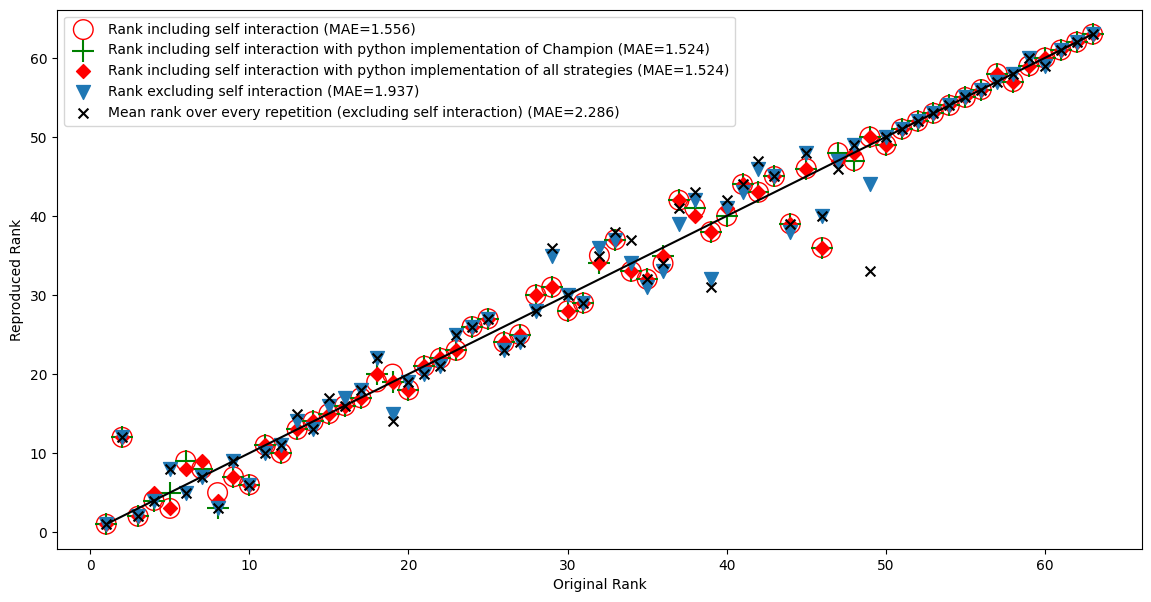

In [25]:
plt.subplots(1, figsize=(14, 7))

self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                      scores["Rank"])
self_interaction_py_ch_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                            py_ch_scores["Rank"])
self_interaction_py_all_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                              py_scores["Rank"])
excl_self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                           original_score_summary["mean"].rank(ascending=False))
mean_rank_mean_abs_error = mean_absolute_error(scores["Original Rank"],
                                               original_rank_summary["mean"].rank(ascending=True))
# TODO: Add more error calculations


plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], 
            label="Rank including self interaction (MAE={:.3f})".format(self_interaction_mean_abs_error),
            s=200,
            facecolors='none', edgecolors='r')
plt.scatter(py_ch_scores["Original Rank"], py_ch_scores["Rank"], 
            label="Rank including self interaction with python implementation of Champion (MAE={:.3f})".format(self_interaction_py_ch_mean_abs_error),
            s=250,
            facecolors='g',
            marker="+")
plt.scatter(py_scores["Original Rank"], py_scores["Rank"], 
            label="Rank including self interaction with python implementation of all strategies (MAE={:.3f})".format(self_interaction_py_all_mean_abs_error),
            s=50,
            facecolors='r',
            marker="D")
plt.scatter(scores["Original Rank"], 
            original_score_summary["mean"].rank(ascending=False), 
            label="Rank excluding self interaction (MAE={:.3f})".format(excl_self_interaction_mean_abs_error), 
            s=100,
            marker="v",)
plt.scatter(scores["Original Rank"], original_rank_summary["mean"].rank(ascending=True), 
            label="Mean rank over every repetition (excluding self interaction) (MAE={:.3f})".format(mean_rank_mean_abs_error),
            s=50,
            marker="x",
            color="black")
plt.xlabel("Original Rank")
plt.ylabel("Reproduced Rank")
plt.legend()
plt.savefig("../assets/original_tournament_rankings_all_approaches.pdf", transparent=True);

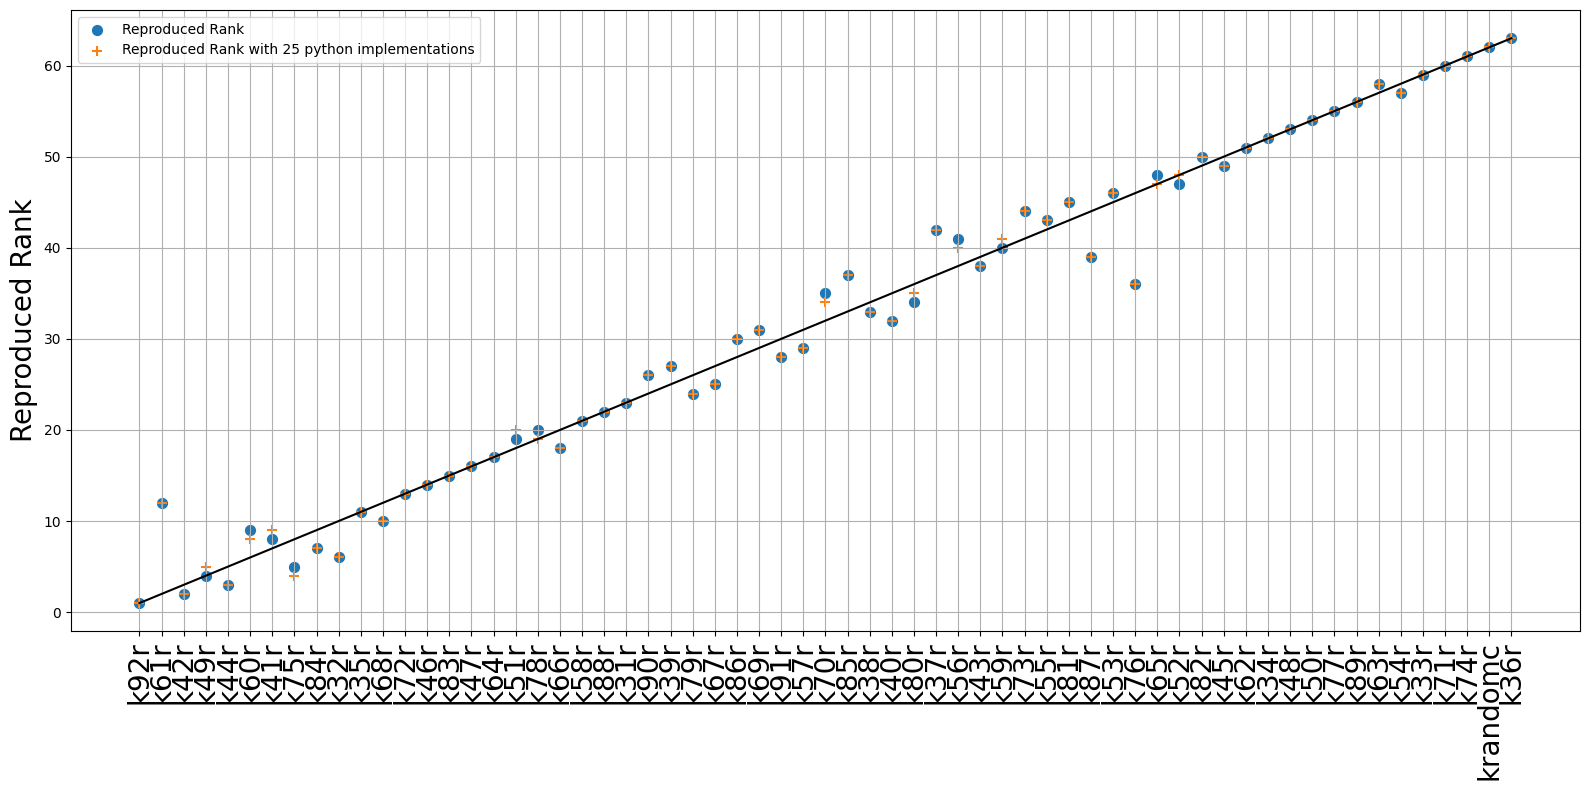

In [26]:
plt.subplots(1, figsize=(16, 8))

self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                      scores["Rank"])
excl_self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                           original_score_summary["mean"].rank(ascending=False))
mean_rank_mean_abs_error = mean_absolute_error(scores["Original Rank"],
                                               original_rank_summary["mean"].rank(ascending=True))

plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], label="Reproduced Rank", s=50)
number_of_python_implementations = len(python_strategies)
plt.scatter(py_scores["Original Rank"], py_scores["Rank"], 
            label="Reproduced Rank with {} python implementations".format(number_of_python_implementations), 
            s=50, marker="+")

plt.xticks(range(1, len(scores.index) + 1), scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced Rank", fontsize=20)
plt.grid()
plt.legend()
plt.tight_layout()

Having examined the remaining outliers I do not see any immediate reason for the discrepancy.

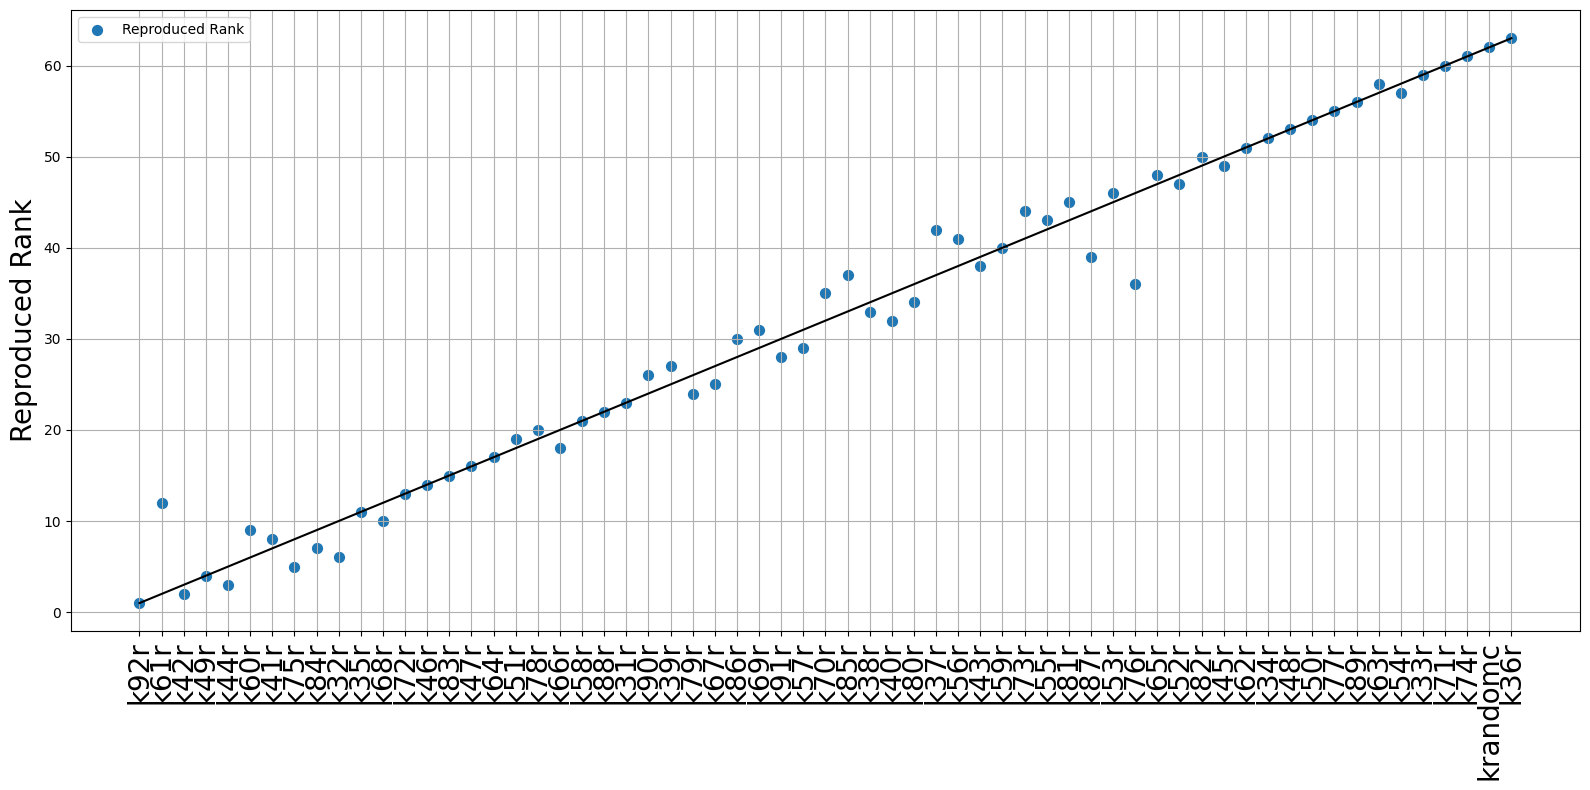

In [27]:
plt.subplots(1, figsize=(16, 8))



plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], label="Reproduced Rank", s=50)
plt.xticks(range(1, len(scores.index) + 1), scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced Rank", fontsize=20)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../assets/original_tournament_rankings.pdf", transparent=True);

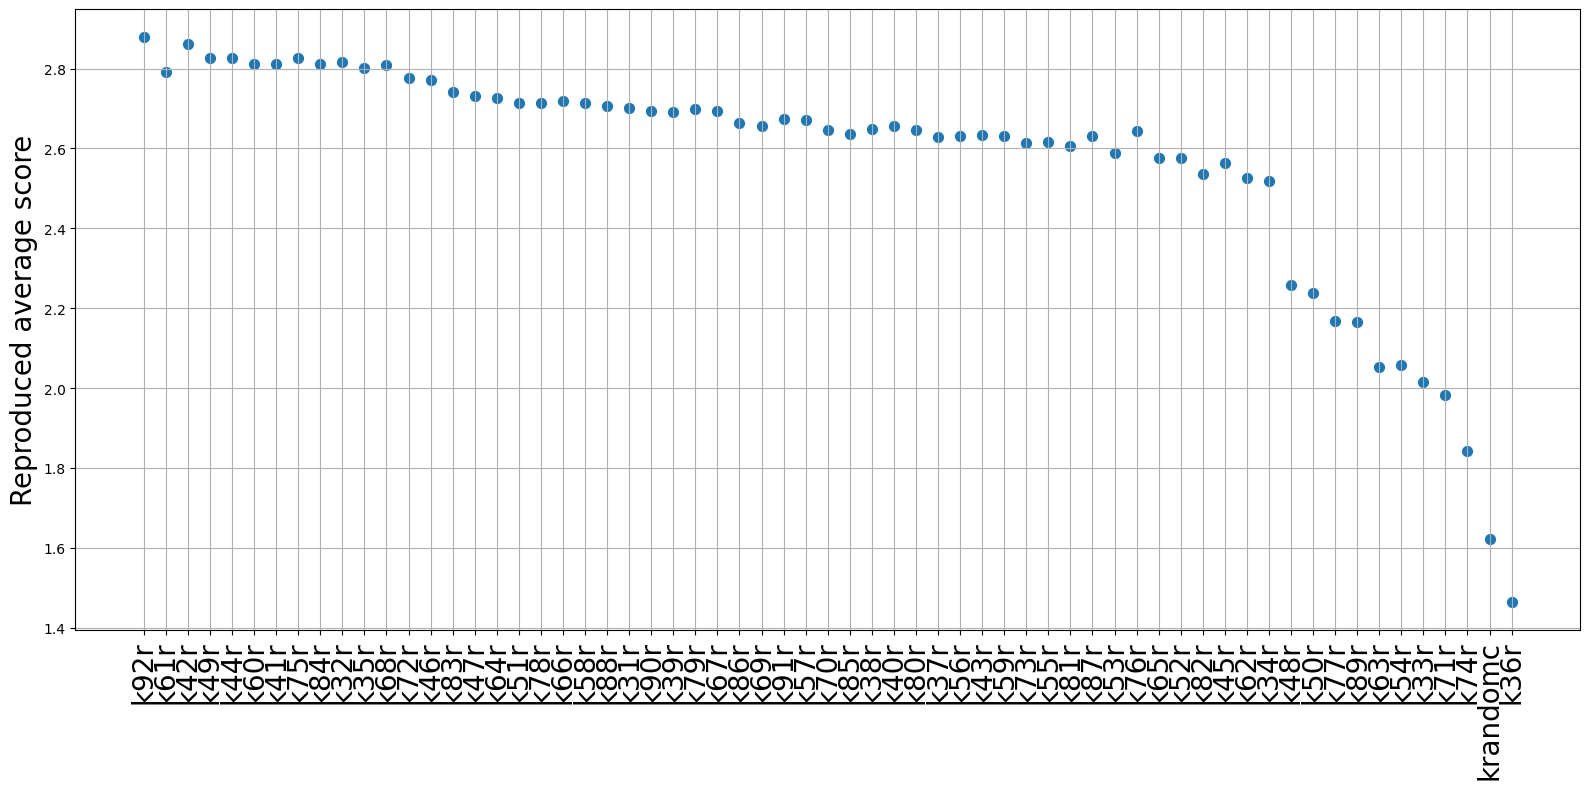

In [28]:
xs = range(len(scores.index))
plt.subplots(1, figsize=(16, 8))
plt.scatter(xs, scores["Scores"].values, s=50)
plt.xticks(xs, scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced average score", fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("../assets/original_tournament_scores.pdf", transparent=True);

Let us get the cooperation rates of each strategy:

In [29]:
original_tournament_cooperation_rates = read_payoff_matrix(original_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()
cooperation_rates = pd.DataFrame(original_tournament_cooperation_rates, 
                                 second_tournament_strategies, 
                                 columns=second_tournament_strategies)
original_cooperation_rates = cooperation_rates.merge(scores[["Rank"]], left_index=True, right_index=True)
original_cooperation_rates["Mean Cooperation Rate"] = np.mean(original_tournament_cooperation_rates, axis=1)
original_cooperation_rates.sort_values("Rank", inplace=True)
original_cooperation_rates

k31r      k32r      k33r      k34r      k35r      k36r  \
k92r      1.000000  1.000000  0.933775  1.000000  1.000000  0.097477   
k42r      1.000000  1.000000  0.129801  1.000000  1.000000  0.151226   
k44r      1.000000  1.000000  0.522962  1.000000  1.000000  0.125935   
k49r      1.000000  1.000000  0.368075  1.000000  1.000000  0.074626   
k75r      0.772980  0.978523  0.730841  0.291391  0.972161  0.421730   
...            ...       ...       ...       ...       ...       ...   
k33r      0.267550  0.387853  0.933775  0.079470  0.789923  0.094309   
k71r      0.501987  0.019723  0.468874  0.013245  0.021355  0.059519   
k74r      0.498013  0.230291  0.006623  0.006623  0.189130  0.009055   
krandomc  0.499711  0.500005  0.500486  0.499918  0.499279  0.499722   
k36r      0.091556  0.091506  0.091711  0.091485  0.091742  0.091648   

              k37r      k38r      k39r      k40r  ...      k86r      k87r  \
k92r      1.000000  1.000000  0.993377  1.000000  ...  1.000000  1.000000   
k42r      1.000000  1.000000  0.993377  1.000000  ...  1.000000  1.000000   
k44r      1.000000  1.000000  0.867797  1.000000  ...  1.000000  1.000000   
k49r      1.000000  1.000000  0.973370  1.000000  ...  1.000000  1.000000   
k75r      0.737417  0.773043  0.943791  0.969222  ...  0.434959  0.831532   
...            ...       ...       ...       ...  ...       ...       ...   
k33r      0.079470  0.267550  0.300662  0.519221  ...  0.132450  0.130012   
k71r      0.013245  0.501987  0.471523  0.015885  ...  0.013245  0.124150   
k74r      0.006623  0.026490  0.099338  0.040084  ...  0.039735  0.013469   
krandomc  0.498818  0.499633  0.500118  0.499545  ...  0.499811  0.499314   
k36r      0.091717  0.091689  0.091523  0.091376  ...  0.091270  0.091772   

              k88r      k89r      k90r      k91r      k92r  krandomc  Rank  \
k92r      1.000000  0.703311  1.000000  1.000000  1.000000  0.504533     1   
k42r      1.000000  0.854305  1.000000  1.000000  1.000000  0.136201     2   
k44r      1.000000  0.700661  1.000000  1.000000  1.000000  0.532069     3   
k49r      1.000000  0.601949  1.000000  1.000000  1.000000  0.204614     4   
k75r      0.889183  0.852980  0.772924  0.792917  0.993377  0.191580     5   
...            ...       ...       ...       ...       ...       ...   ...   
k33r      0.224903  0.319205  0.504636  0.278146  0.933775  0.157565    59   
k71r      0.058741  0.282119  0.501987  0.258278  0.013245  0.257829    60   
k74r      0.058363  0.438411  0.370861  0.026490  0.498013  0.027631    61   
krandomc  0.499389  0.499646  0.500540  0.500802  0.501244  0.499220    62   
k36r      0.091827  0.091436  0.091928  0.091687  0.091235  0.091701    63   

          Mean Cooperation Rate  
k92r                   0.921831  
k42r                   0.916128  
k44r                   0.881894  
k49r                   0.892220  
k75r                   0.801931  
...                         ...  
k33r                   0.410634  
k71r                   0.157546  
k74r                   0.173823  
krandomc               0.499971  
k36r                   0.091591  

[63 rows x 65 columns]

In [30]:
ranking_df = scores[["Author", "Scores", "Rank", "Original Rank"]].round(4)
ranking_df = ranking_df.join(original_cooperation_rates[["Mean Cooperation Rate"]])
ranking_df.head()

Author  Scores  Rank  Original Rank  Mean Cooperation Rate
k92r   Anatol Rapoport  2.8785     1              1               0.921831
k61r  Danny C Champion  2.7907    12              2               0.954240
k42r     Otto Borufsen  2.8607     2              3               0.916128
k49r          Rob Cave  2.8260     4              4               0.892220
k44r     William Adams  2.8260     3              5               0.881894

In [31]:
with open("../assets/original_tournament_rankings.tex", "w") as f:
    f.write(ranking_df.head(15).to_latex(float_format="%.3f"))

Axelrod's original paper mentioned 5 strategies as representatives: https://github.com/Axelrod-Python/revisiting-axelrod-second/issues/3

Let us reproduce this.

In [32]:
scores[second_tournament_strategies]

k31r      k32r      k33r      k34r      k35r      k36r  \
k92r      3.000000  3.000000  2.900662  3.000000  3.000000  1.257422   
k61r      3.000000  3.000000  2.854305  3.000000  3.000000  1.112628   
k42r      3.000000  3.000000  2.137748  3.000000  3.000000  1.199216   
k49r      3.000000  3.000000  2.279602  3.000000  3.000000  1.286362   
k44r      3.000000  3.000000  2.360991  3.000000  3.000000  1.227057   
...            ...       ...       ...       ...       ...       ...   
k33r      1.315232  1.273490  2.867550  0.986755  2.723067  1.262991   
k71r      3.996026  1.095208  3.830464  1.033113  1.104713  1.300448   
k74r      2.509934  1.744567  1.304636  1.019868  1.561121  1.356863   
krandomc  2.360713  0.960745  1.050703  0.547155  2.270139  0.821423   
k36r      0.944917  1.356604  1.275984  0.937150  1.314867  1.265262   

              k37r      k38r      k39r      k40r  ...      k84r      k85r  \
k92r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  3.000000   
k61r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  3.000000   
k42r      3.000000  3.000000  2.993377  3.000000  ...  3.000000  3.000000   
k49r      3.000000  3.000000  2.904710  3.000000  ...  3.000000  3.000000   
k44r      3.000000  3.000000  2.791589  3.000000  ...  3.000000  3.000000   
...            ...       ...       ...       ...  ...       ...       ...   
k33r      0.986755  1.315232  1.258278  1.204787  ...  1.468874  1.316556   
k71r      1.033113  3.996026  3.825166  1.064943  ...  2.153642  1.105960   
k74r      1.019868  1.099338  1.585430  1.060795  ...  1.656954  1.072848   
krandomc  0.567035  0.829025  1.423339  1.148856  ...  0.641308  0.749496   
k36r      0.936958  1.004248  1.496593  1.082336  ...  1.840347  1.311784   

              k86r      k87r      k88r      k89r      k90r      k91r  \
k92r      3.000000  3.000000  3.000000  2.635762  3.000000  3.000000   
k61r      3.000000  3.000000  3.000000  2.530366  3.000000  3.000000   
k42r      3.000000  3.000000  3.000000  2.621192  3.000000  3.000000   
k49r      3.000000  3.000000  3.000000  2.364432  3.000000  3.000000   
k44r      3.000000  3.000000  3.000000  2.446443  3.000000  3.000000   
...            ...       ...       ...       ...       ...       ...   
k33r      1.006623  1.840296  2.059480  1.613245  3.891391  2.058278   
k71r      1.059603  1.808232  1.343227  2.770861  3.996026  2.773510   
k74r      1.059603  1.972933  1.571168  2.165563  3.390728  1.262252   
krandomc  0.974552  1.270627  2.348461  1.822680  3.136656  1.547000   
k36r      0.973240  1.859922  1.496373  1.671715  1.632318  1.458383   

              k92r  krandomc  
k92r      3.000000  2.247304  
k61r      3.000000  1.875764  
k42r      3.000000  2.798713  
k49r      3.000000  2.694843  
k44r      3.000000  2.204224  
...            ...       ...  
k33r      2.900662  2.765306  
k71r      1.059603  2.609430  
k74r      2.509934  2.959641  
krandomc  2.263748  2.248527  
k36r      1.288632  2.861525  

[63 rows x 63 columns]

Let us do this by picking up to 25 strategies against which to fit a linear model.

In [33]:
r_squared_values = []
max_n_features_to_select = 25
for number_of_strategies in range(1, max_n_features_to_select + 1):
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, n_features_to_select=number_of_strategies, scoring='r2', direction='forward', n_jobs=-1)
    fit = sfs.fit(scores[second_tournament_strategies], scores["Scores"])
    model.fit(scores[second_tournament_strategies].iloc[:,fit.support_], scores["Scores"])
    scores["Predicted scores {} strategies".format(number_of_strategies)] = model.predict(scores[second_tournament_strategies].iloc[:,fit.support_])
    r_squared_values.append(r2_score(scores["Scores"], 
                                     scores["Predicted scores {} strategies".format(number_of_strategies)]))
    print(number_of_strategies)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


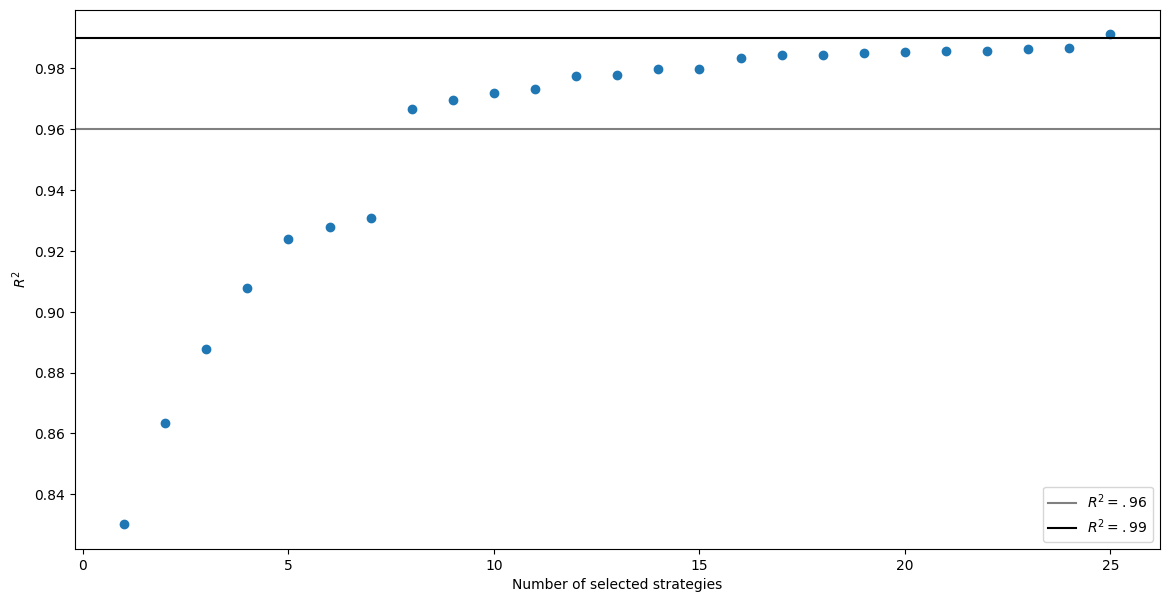

In [34]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(range(1, max_n_features_to_select + 1), r_squared_values)
plt.axhline(.96, label="$R^2=.96$", color="grey")
plt.axhline(.99, label="$R^2=.99$", color="black")
plt.xlabel("Number of selected strategies")
plt.ylabel("$R^2$")
plt.legend()
plt.savefig("../assets/original_tournament_r_squared_versus_number_of_features.pdf", transparent=True)

In [35]:
def write_linear_model_to_file(file_prefix, number_of_strategies=None, strategies=None):
    model = LinearRegression()
    Y =  scores["Scores"]
    
    if strategies is None:
        rfe = RFE(model, n_features_to_select=number_of_strategies)
        X = scores[second_tournament_strategies]
        fit = rfe.fit(X, Y)
        strategies = [name 
              for i, name in enumerate(second_tournament_strategies)
              if fit.support_[i]]      
        
    X = scores[strategies]
    model.fit(X, Y)
    

    coefficients = model.coef_
    intercept = model.intercept_
    
    F_values, p_values = f_regression(X, Y)
        
    
    with open("../assets/" + file_prefix + "_{}_model.tex".format(number_of_strategies).replace("None_", "",), "w") as f:
        f.write(pd.DataFrame({"Strategies": strategies + ["Intercept"], 
                              "Coefficients": list(coefficients) + [intercept], 
                              "$p$-value": list(p_values) + ["NA"],
                              "$F$-value": list(F_values) + ["NA"]}
                            )[["Strategies", "Coefficients", "$p$-value", "$F$-value"]].round(5).to_latex(index=False).replace("\\$", "$"))
    
    if number_of_strategies is not None:
        r_squared = r2_score(scores["Scores"], 
                             scores["Predicted scores {} strategies".format(number_of_strategies)])
    else:
        r_squared = r2_score(scores["Scores"], 
                             model.predict(X))
    with open("../assets/" + file_prefix + "_{}_r_squared.tex".format(number_of_strategies).replace("None_", "",), "w") as f:
        f.write("{:.3f}".format(r_squared))
        
    with open("data/linear_regression/" + file_prefix + "_{}_strategies.csv".format(number_of_strategies).replace("None_", "",), "w") as f:
        for player, weight in zip(strategies, coefficients):
            f.write("{},{}\n".format(player, weight))
        
    return model, r_squared

In [36]:
for number in [5, 8, 25]:
    write_linear_model_to_file(file_prefix="original_tournament_predictive", 
                               number_of_strategies=number)

In [37]:
representative_strategies = ['k69r', 'k91r', 'k40r', 'k76r', 'k67r']
coefficients = [0.202, 0.198, 0.110, 0.072, 0.086]
intercept= 120 / 151
scores["Representative scores"] = intercept + sum(
                                            scores[strategy] * coefficient 
                                            for strategy, coefficient in zip(representative_strategies, 
                                                                             coefficients))


    
with open("../assets/original_tournament_representative_model.tex", "w") as f:
    f.write(pd.DataFrame({"Strategies": representative_strategies + ["Intercept"], 
                          "Coefficients": list(coefficients) + [intercept]}
                        )[["Strategies", "Coefficients"]].round(3).to_latex(index=False))
    
    
representative_r_squared = r2_score(scores["Scores"], scores["Representative scores"])
with open("../assets/original_tournament_representative_r_squared.tex", "w") as f:
    f.write("{:.4f}".format(representative_r_squared))
    
with open("data/linear_regression/original_tournament_representative_strategies.csv", "w") as f:
    for player, weight in zip(representative_strategies, coefficients):
        f.write("{},{}\n".format(player, weight))

In [38]:
linear_model_with_original_5, linear_model_with_original_5_r_squared  = write_linear_model_to_file(
                           file_prefix="original_tournament_predictive_with_axelrod_5", 
                           strategies=representative_strategies)

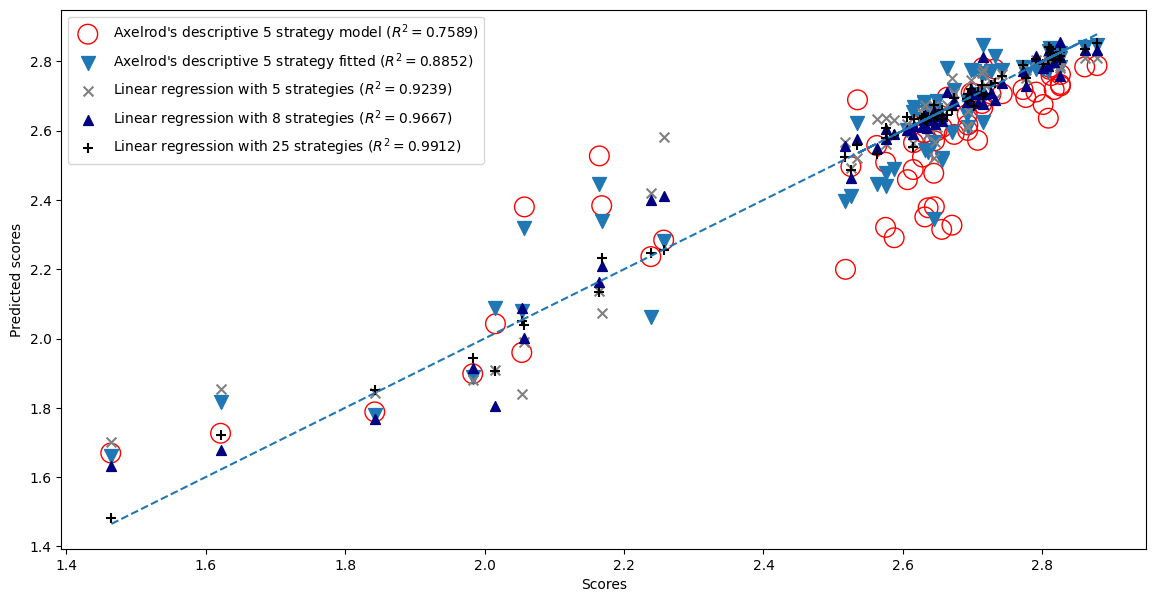

In [39]:
plt.subplots(1, figsize=(14, 7))

plt.plot(scores["Scores"], scores["Scores"], linestyle="dashed")
plt.scatter(scores["Scores"], scores["Representative scores"], 
            label="Axelrod's descriptive 5 strategy model ($R^2={:.4f}$)".format(representative_r_squared),
            s=200,
            facecolors='none', edgecolors='r')

plt.scatter(scores["Scores"], linear_model_with_original_5.predict(scores[representative_strategies]), 
            label="Axelrod's descriptive 5 strategy fitted ($R^2={:.4f}$)".format(linear_model_with_original_5_r_squared),
            s=100,
            marker="v",)
plt.scatter(scores["Scores"], scores["Predicted scores 5 strategies"], 
            label="Linear regression with 5 strategies ($R^2={:.4f}$)".format(r_squared_values[4]),
            s=50,
            marker="x",
            color="grey")
plt.scatter(scores["Scores"], scores["Predicted scores 8 strategies"], 
            label="Linear regression with 8 strategies ($R^2={:.4f}$)".format(r_squared_values[7]),
            s=50,
            marker="^",
            color="navy")
plt.scatter(scores["Scores"], scores["Predicted scores 25 strategies"], 
            label="Linear regression with 25 strategies ($R^2={:.4f}$)".format(r_squared_values[24]),
            s=50,
            marker="+",
            color="black")

plt.legend()
plt.xlabel("Scores")
plt.ylabel("Predicted scores")
plt.savefig("../assets/original_tournament_predictive_score_models.pdf", transparent=True);

# What was the tournament "like"

Let us take a look at summary statistics and cooperation rates.

In [40]:
with open("../assets/original_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(original_tournament_cooperation_rates)))
np.mean(original_tournament_cooperation_rates)

np.float64(0.750372377314919)

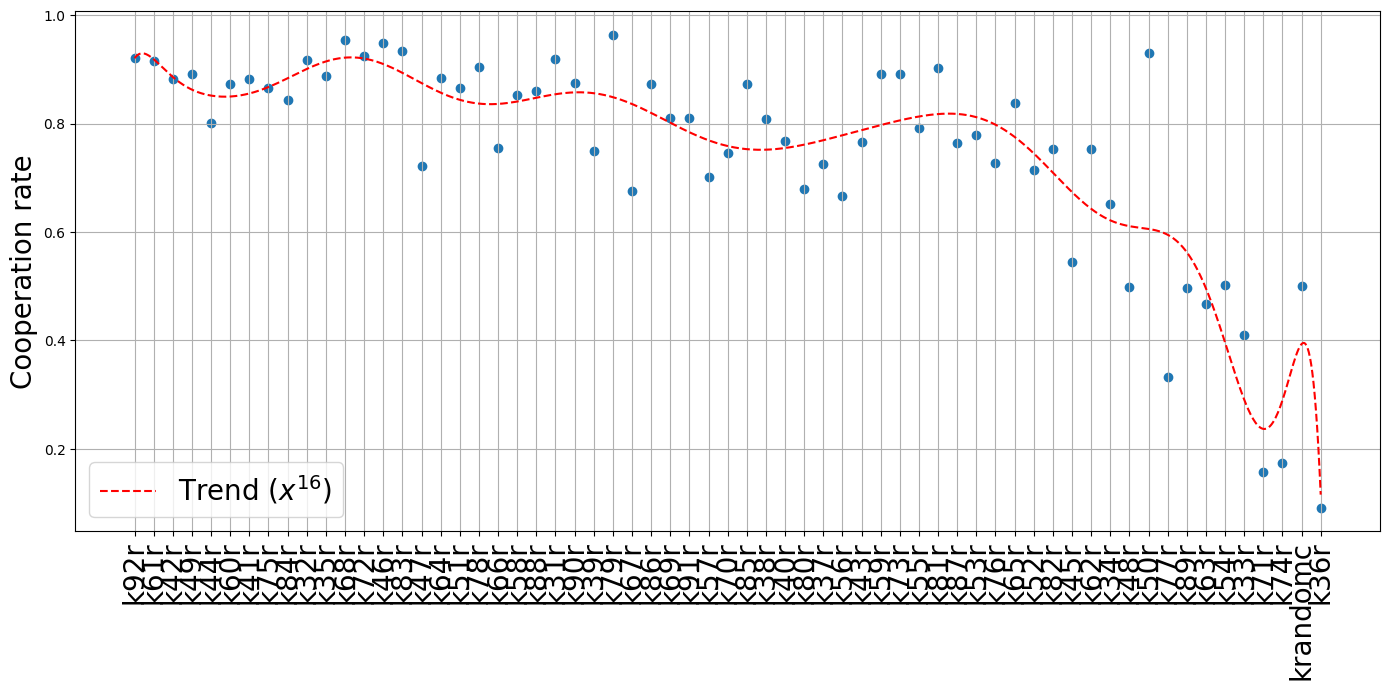

In [41]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(ranking_df["Rank"], ranking_df["Mean Cooperation Rate"])

degree = 16
z = np.polyfit(ranking_df["Rank"], ranking_df["Mean Cooperation Rate"], degree)
p = np.poly1d(z)
x = np.linspace(1, ranking_df["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend ($x^{{{}}}$)".format(degree))

plt.ylabel("Cooperation rate", fontsize=20)
plt.xticks(range(1, len(ranking_df.index) + 1), ranking_df.index, rotation=90, fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("../assets/original_tournament_cooperation_rate_versus_rank.pdf", transparent=True)

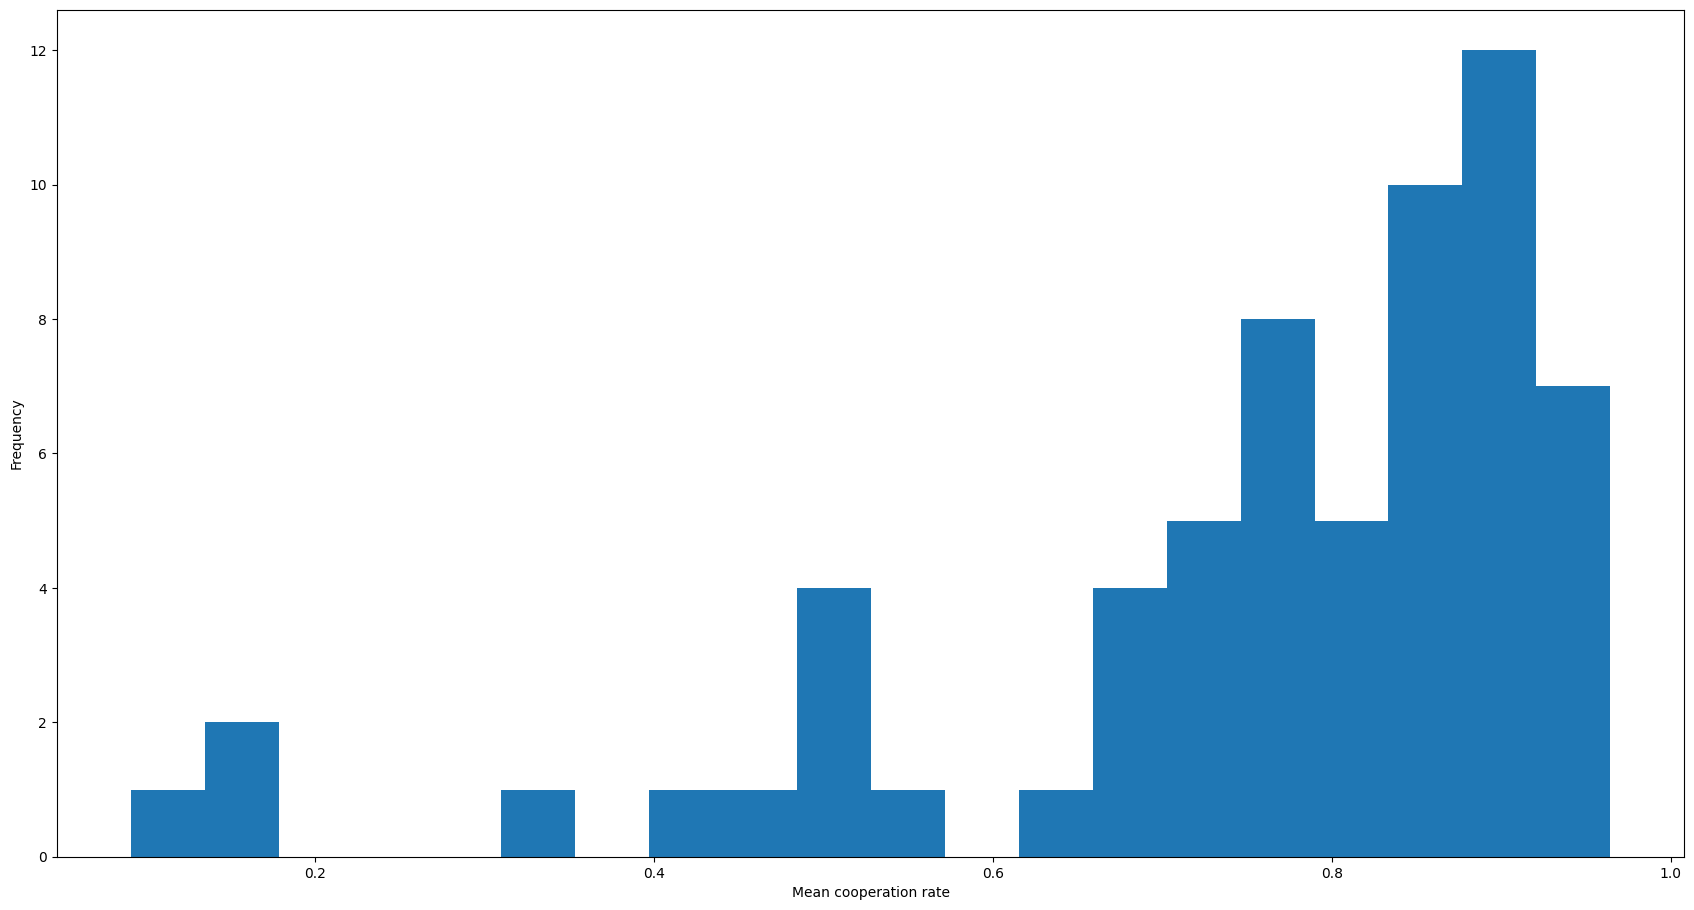

In [42]:
plt.subplots(1, figsize=(21, 11))

plt.hist(ranking_df["Mean Cooperation Rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/original_tournament_cooperation_rates.pdf", transparent=True)

In [43]:
def matrix_heatmap(matrix, player_names, filename):
    number_of_players = len(player_names)
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(player_names, rotation=90)
    ax.set_yticklabels(player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename, transparent=True);

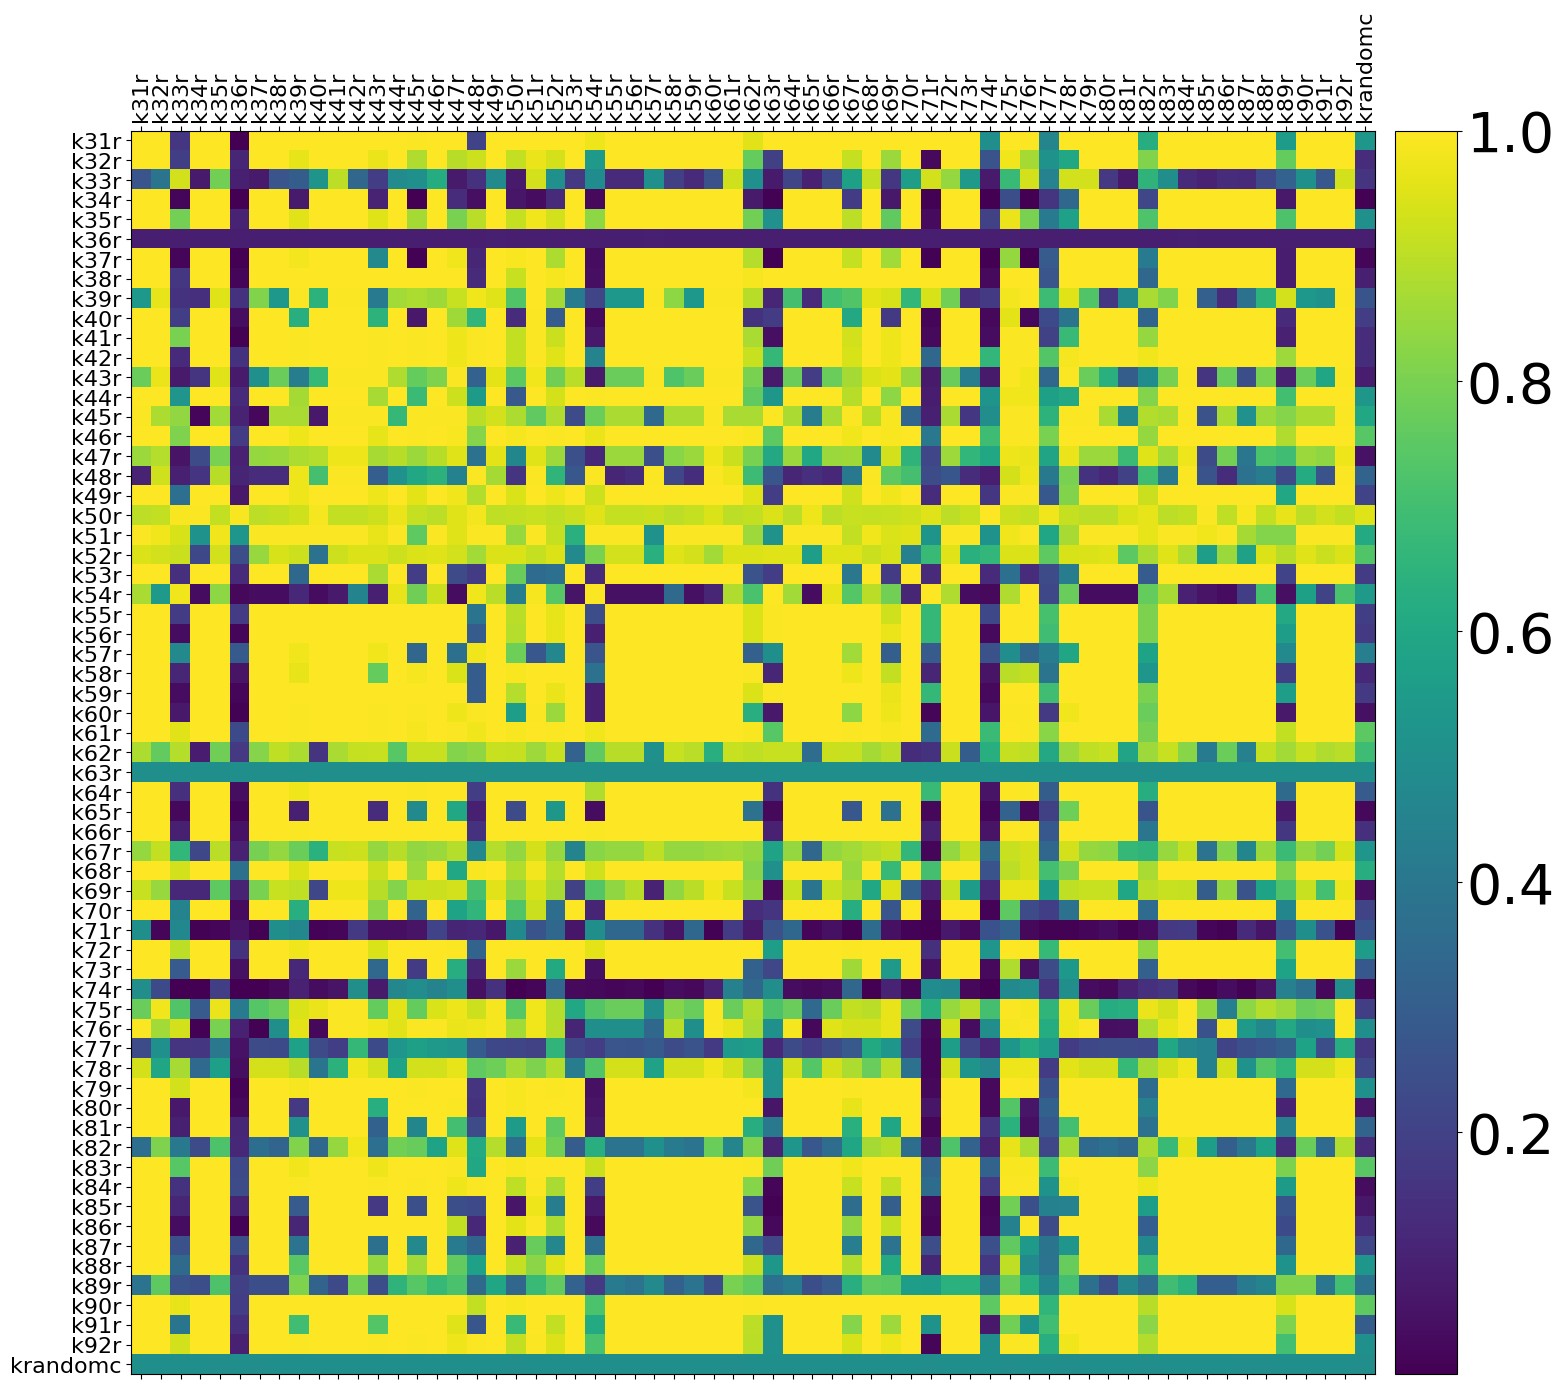

In [44]:
matrix_heatmap(cooperation_rates[cooperation_rates.index], cooperation_rates.index, 
               "../assets/original_tournament_pairwise_cooperation_rates.pdf")

# Running a full tournament

In [45]:
full_tournament_data_path = pathlib.Path("./data/full_tournament/")
full_tournament_index = pd.read_csv(
    "./data/full_tournament/players.index",
    names=("Name",),
)
full_tournament_scores = read_tournament_repetitions(
                                   files=full_tournament_data_path.glob("*scores.gz"), 
                                   player_names=full_tournament_index["Name"],
)

In [46]:
full_tournament_payoff_matrix, full_repetitions = read_payoff_matrix(full_tournament_data_path.glob("*payoff_matrix.gz"))
library_summary_df = pd.read_csv("./data/library_tournament/std_summary.csv")[["Rank", "Name", "Cooperation_rating"]]
library_summary_df = library_summary_df.set_index("Name")
library_summary_df["Rank"] += 1
library_summary_df = library_summary_df.rename(columns={"Rank": "Library Rank", "Cooperation_rating": "Library Mean Cooperation Rate"})

In [47]:
full_tournament_cooperation_rate_matrix = read_payoff_matrix(full_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()
full_scores = pd.DataFrame(full_tournament_payoff_matrix, 
                           full_tournament_index["Name"],
                           columns=full_tournament_index["Name"])
full_scores["Mean Score"] = np.mean(full_tournament_payoff_matrix, axis=1)
full_scores["Rank"] = full_scores["Mean Score"].rank(ascending=False).astype(int)

cooperation_rates = pd.DataFrame(full_tournament_cooperation_rate_matrix, 
                                 full_tournament_index["Name"], 
                                 columns=full_tournament_index["Name"])
cooperation_rates["Mean Cooperation Rate"] =  np.mean(full_tournament_cooperation_rate_matrix, axis=1)


full_scores = full_scores.join(cooperation_rates[["Mean Cooperation Rate"]]).sort_values("Rank")

full_ranking_df = full_scores[["Mean Score", "Rank", "Mean Cooperation Rate"]].round(4)
full_ranking_df = pd.merge(full_ranking_df, ranking_df[["Original Rank", "Mean Cooperation Rate"]], left_index=True, right_index=True, how="outer").sort_values("Rank")
full_ranking_df = full_ranking_df.rename(columns={"Mean Cooperation Rate_x": "Mean Cooperation Rate", "Mean Cooperation Rate_y": "Original Mean Cooperation Rate"})


full_ranking_df = full_ranking_df.join(library_summary_df)

full_ranking_df["Original Rank"] = full_ranking_df["Original Rank"].astype(pd.Int64Dtype())
full_ranking_df["Library Rank"] = full_ranking_df["Library Rank"].astype(pd.Int64Dtype())
full_ranking_df["Rank"] = full_ranking_df["Rank"].astype(pd.Int64Dtype())

full_ranking_df.head(25)

Mean Score  Rank  Mean Cooperation Rate  \
EvolvedLookerUp2_2_2            2.8017     1                 0.7564   
Evolved HMM 5                   2.7880     2                 0.7515   
Omega TFT: 3, 8                 2.7857     3                 0.7500   
Evolved ANN 5                   2.7840     4                 0.7204   
Evolved ANN                     2.7823     5                 0.7392   
Evolved FSM 16                  2.7796     6                 0.7308   
Evolved FSM 16 Noise 05         2.7756     7                 0.7261   
PSO Gambler 2_2_2               2.7605     8                 0.7016   
Original Gradual                2.7574     9                 0.8076   
PSO Gambler 2_2_2 Noise 05      2.7557    10                 0.7398   
PSO Gambler Mem1                2.7555    11                 0.7344   
Evolved FSM 4                   2.7525    12                 0.7927   
PSO Gambler 1_1_1               2.7518    13                 0.7038   
Gradual                         2.7462    14                 0.7626   
DBS: 0.75, 3, 4, 3, 5           2.7392    15                 0.7505   
k42r                            2.7345    16                 0.8203   
Winner12                        2.7330    17                 0.6876   
Spiteful Tit For Tat            2.7232    18                 0.6911   
k60r                            2.7225    19                 0.6905   
k85r                            2.7161    20                 0.6272   
EugineNier: (D,)                2.7132    21                 0.6730   
k80r                            2.7063    22                 0.7234   
k32r                            2.7037    23                 0.7580   
DoubleCrosser: (D, D)           2.7034    24                 0.6933   
k58r                            2.7025    25                 0.7456   

                            Original Rank  Original Mean Cooperation Rate  \
EvolvedLookerUp2_2_2                 <NA>                             NaN   
Evolved HMM 5                        <NA>                             NaN   
Omega TFT: 3, 8                      <NA>                             NaN   
Evolved ANN 5                        <NA>                             NaN   
Evolved ANN                          <NA>                             NaN   
Evolved FSM 16                       <NA>                             NaN   
Evolved FSM 16 Noise 05              <NA>                             NaN   
PSO Gambler 2_2_2                    <NA>                             NaN   
Original Gradual                     <NA>                             NaN   
PSO Gambler 2_2_2 Noise 05           <NA>                             NaN   
PSO Gambler Mem1                     <NA>                             NaN   
Evolved FSM 4                        <NA>                             NaN   
PSO Gambler 1_1_1                    <NA>                             NaN   
Gradual                              <NA>                             NaN   
DBS: 0.75, 3, 4, 3, 5                <NA>                             NaN   
k42r                                    3                        0.916128   
Winner12                             <NA>                             NaN   
Spiteful Tit For Tat                 <NA>                             NaN   
k60r                                    6                        0.843981   
k85r                                   33                        0.726390   
EugineNier: (D,)                     <NA>                             NaN   
k80r                                   36                        0.808938   
k32r                                   10                        0.872621   
DoubleCrosser: (D, D)                <NA>                             NaN   
k58r                                   21                        0.852303   

                            Library Rank  Library Mean Cooperation Rate  
EvolvedLookerUp2_2_2                   1                       0.736491  
Evolved HMM 5                 

In [261]:
with open("../assets/number_of_strategies_in_full_tournament.tex", "w") as f:
    f.write(f"{len(full_ranking_df.index)}")

In [48]:
with open("../assets/number_of_full_repetitions.tex", "w") as f:
    f.write(f"{full_repetitions:,}")

In [49]:
with open("../assets/full_tournament_rankings.tex", "w") as f:
    f.write(full_ranking_df.head(25).to_latex(float_format="%.3f").replace("_", "\_").replace("Mean Cooperation", "Coop.").replace("NaN", "NA"))

<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\_'
/var/folders/2p/gzkw2x1n7vb7g7p_c4d43vbw0000gp/T/ipykernel_89642/889417114.py:2: SyntaxWarning: invalid escape sequence '\_'
  f.write(full_ranking_df.head(25).to_latex(float_format="%.3f").replace("_", "\_").replace("Mean Cooperation", "Coop.").replace("NaN", "NA"))


In [50]:
with open("../assets/library_tournament_cooperation_rate.tex", "w") as f:
    f.write(f"{full_ranking_df['Library Mean Cooperation Rate'].mean():.03}")
with open("../assets/full_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write(f"{full_ranking_df['Mean Cooperation Rate'].mean():.03}")

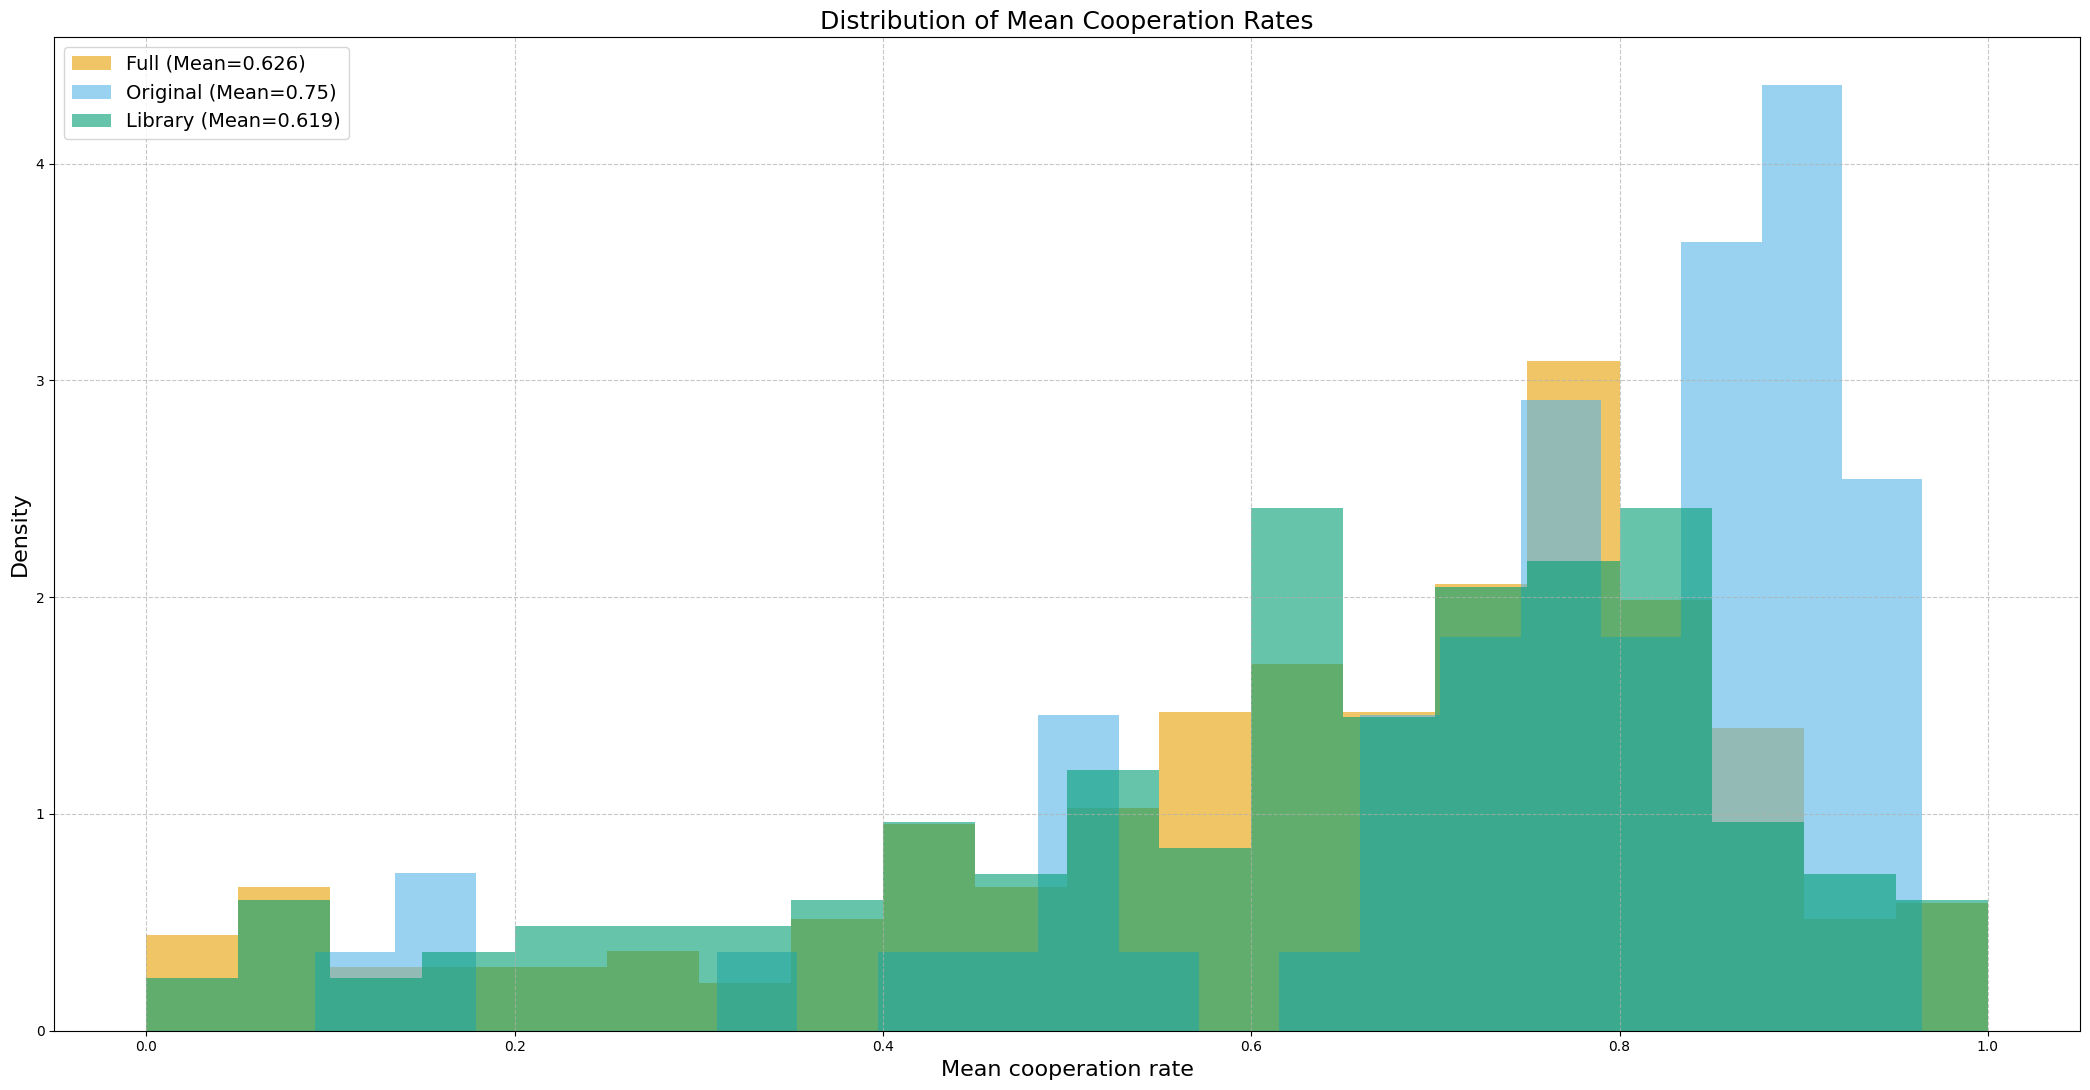

In [51]:
# Color blind friendly colors from Color Universal Design (CUD)
colors = ["#E69F00", "#56B4E9", "#009E73"]

plt.figure(figsize=(21, 11))

plt.hist(
    full_ranking_df["Mean Cooperation Rate"], 
    bins=20, alpha=0.6, label=f"Full (Mean={full_ranking_df['Mean Cooperation Rate'].mean():.03})", color=colors[0],
    density=True,
)
plt.hist(
    full_ranking_df["Original Mean Cooperation Rate"], 
    bins=20, alpha=0.6, label=f"Original (Mean={full_ranking_df['Original Mean Cooperation Rate'].mean():.03})", color=colors[1],
    density=True,
)
plt.hist(
    full_ranking_df["Library Mean Cooperation Rate"], 
    bins=20, alpha=0.6, label=f"Library (Mean={full_ranking_df['Library Mean Cooperation Rate'].mean():.03})", color=colors[2],
    density=True,
)

plt.xlabel("Mean cooperation rate", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Distribution of Mean Cooperation Rates", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("../assets/full_tournament_cooperation_rates.pdf", transparent=True)

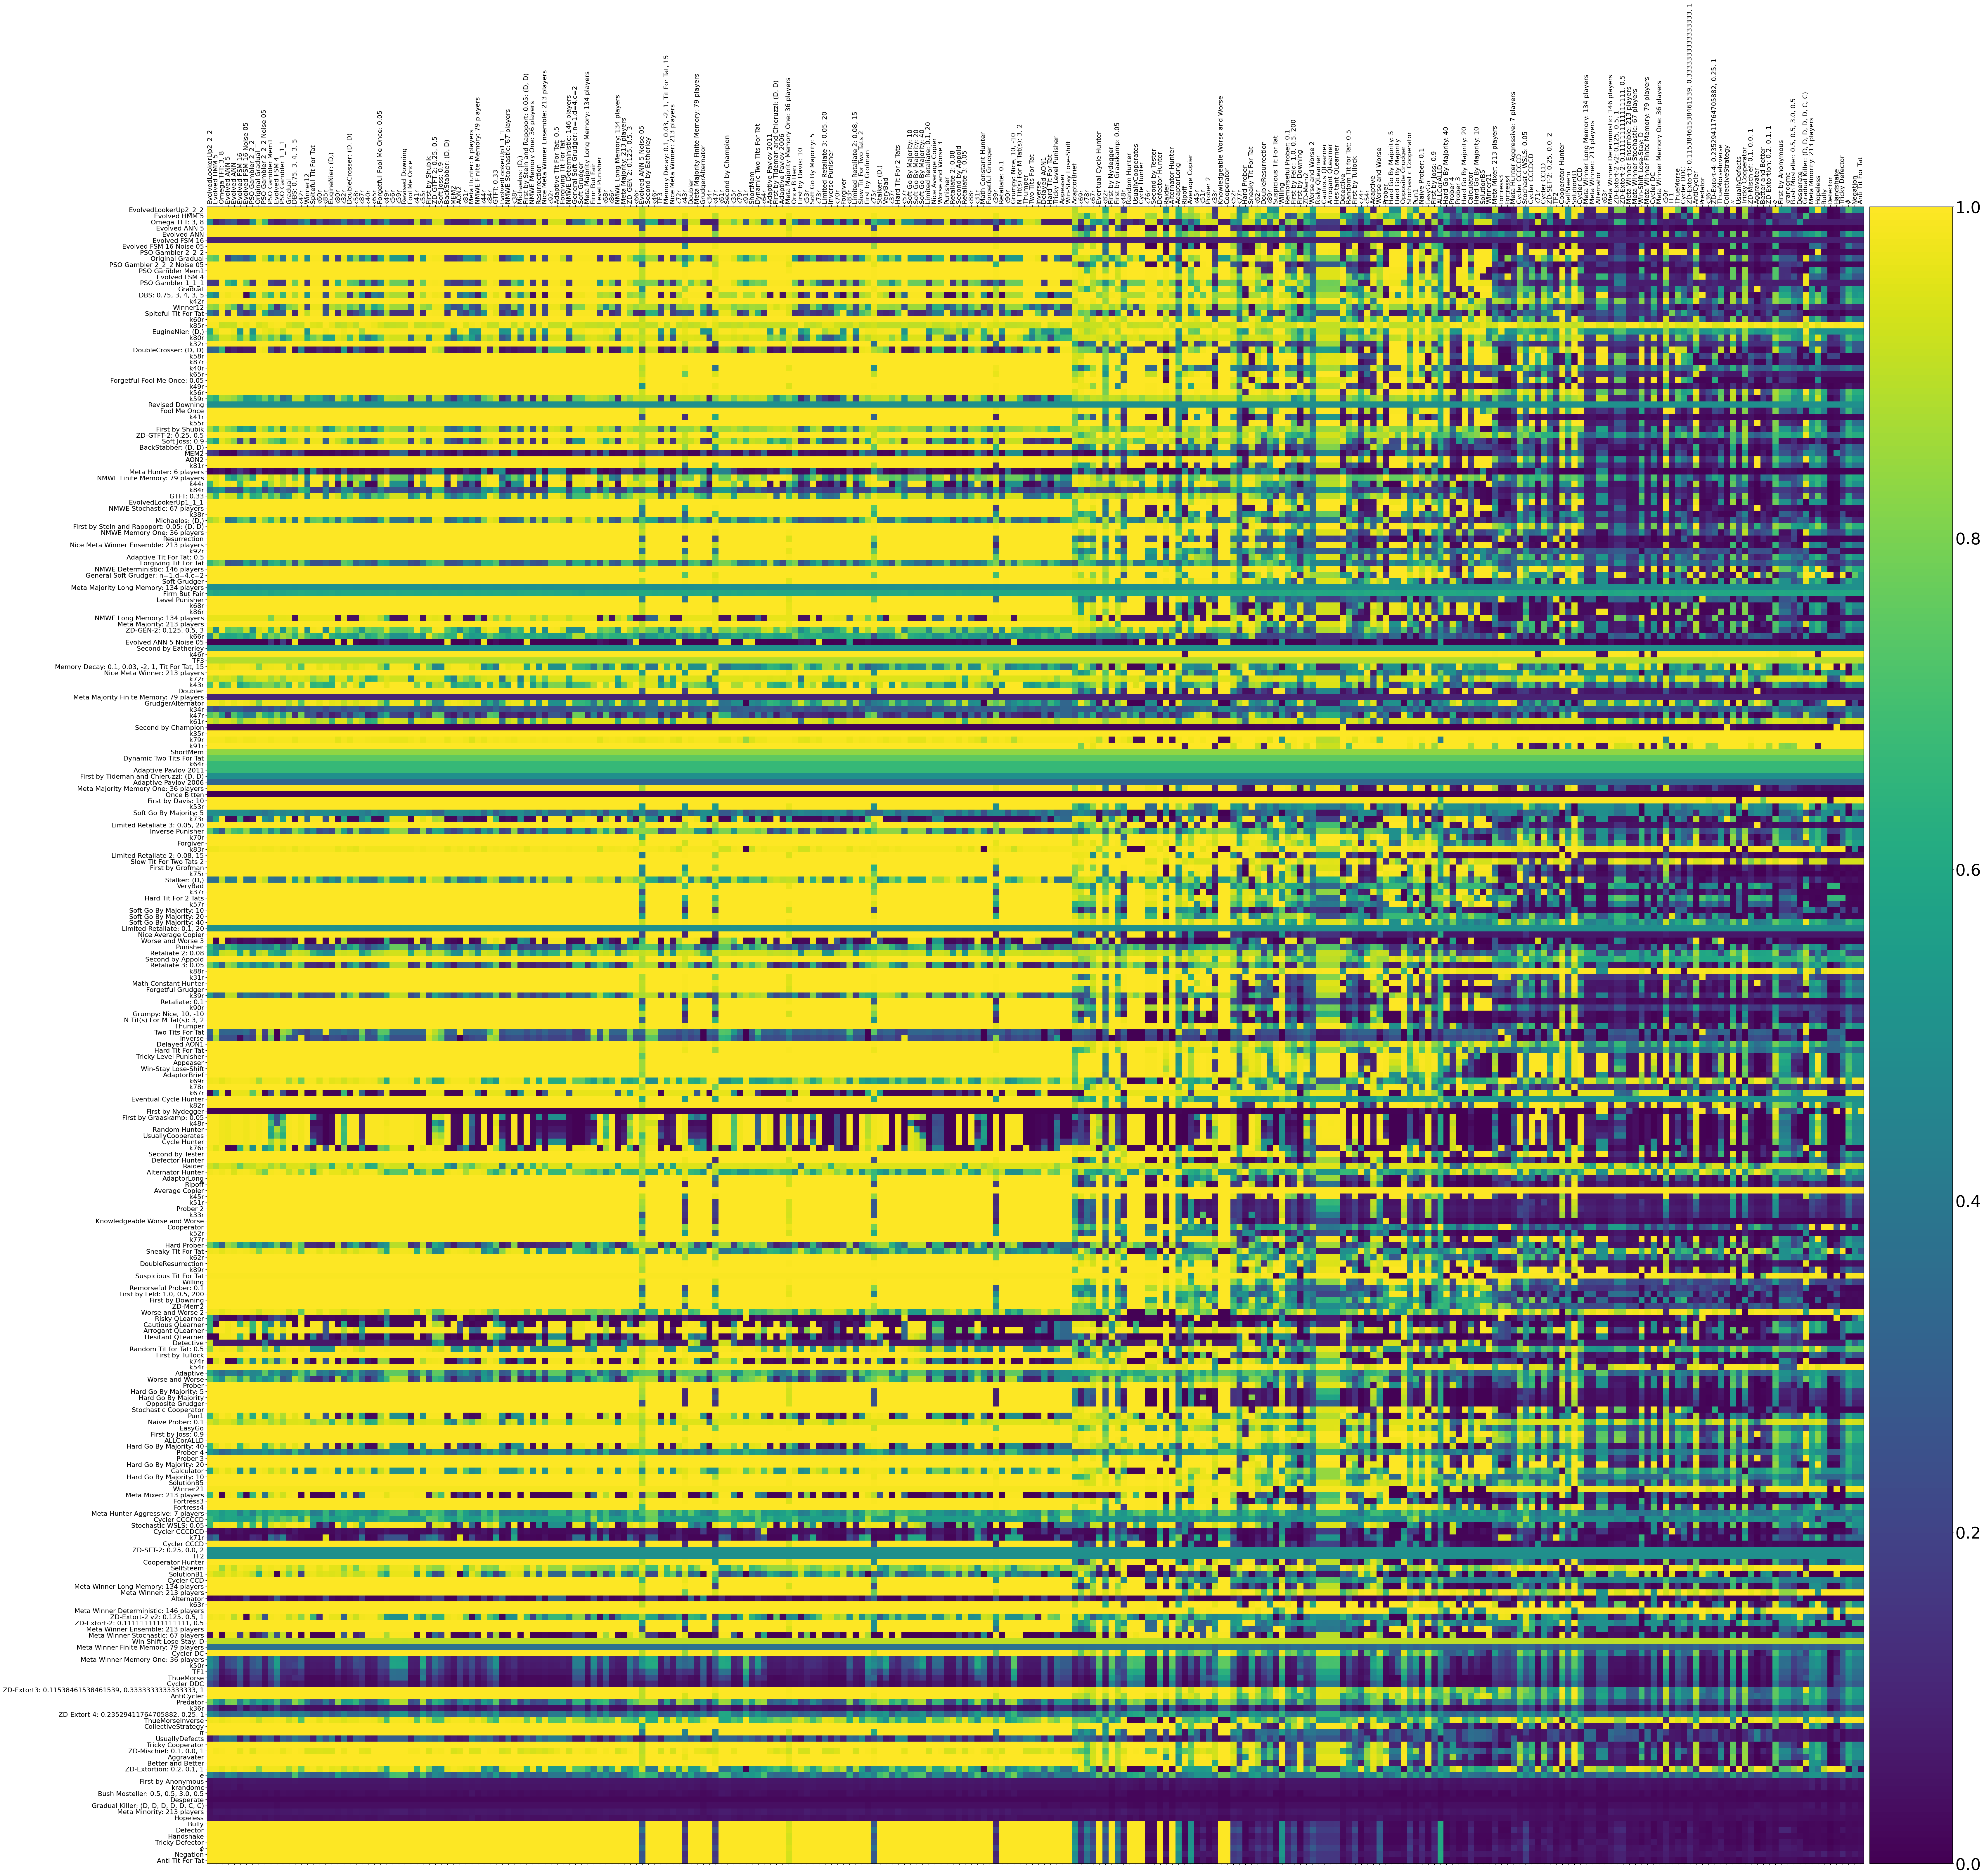

In [52]:
matrix_heatmap(cooperation_rates[full_ranking_df.index], full_ranking_df.index, 
               "../assets/full_tournament_pairwise_cooperation_rates.pdf")

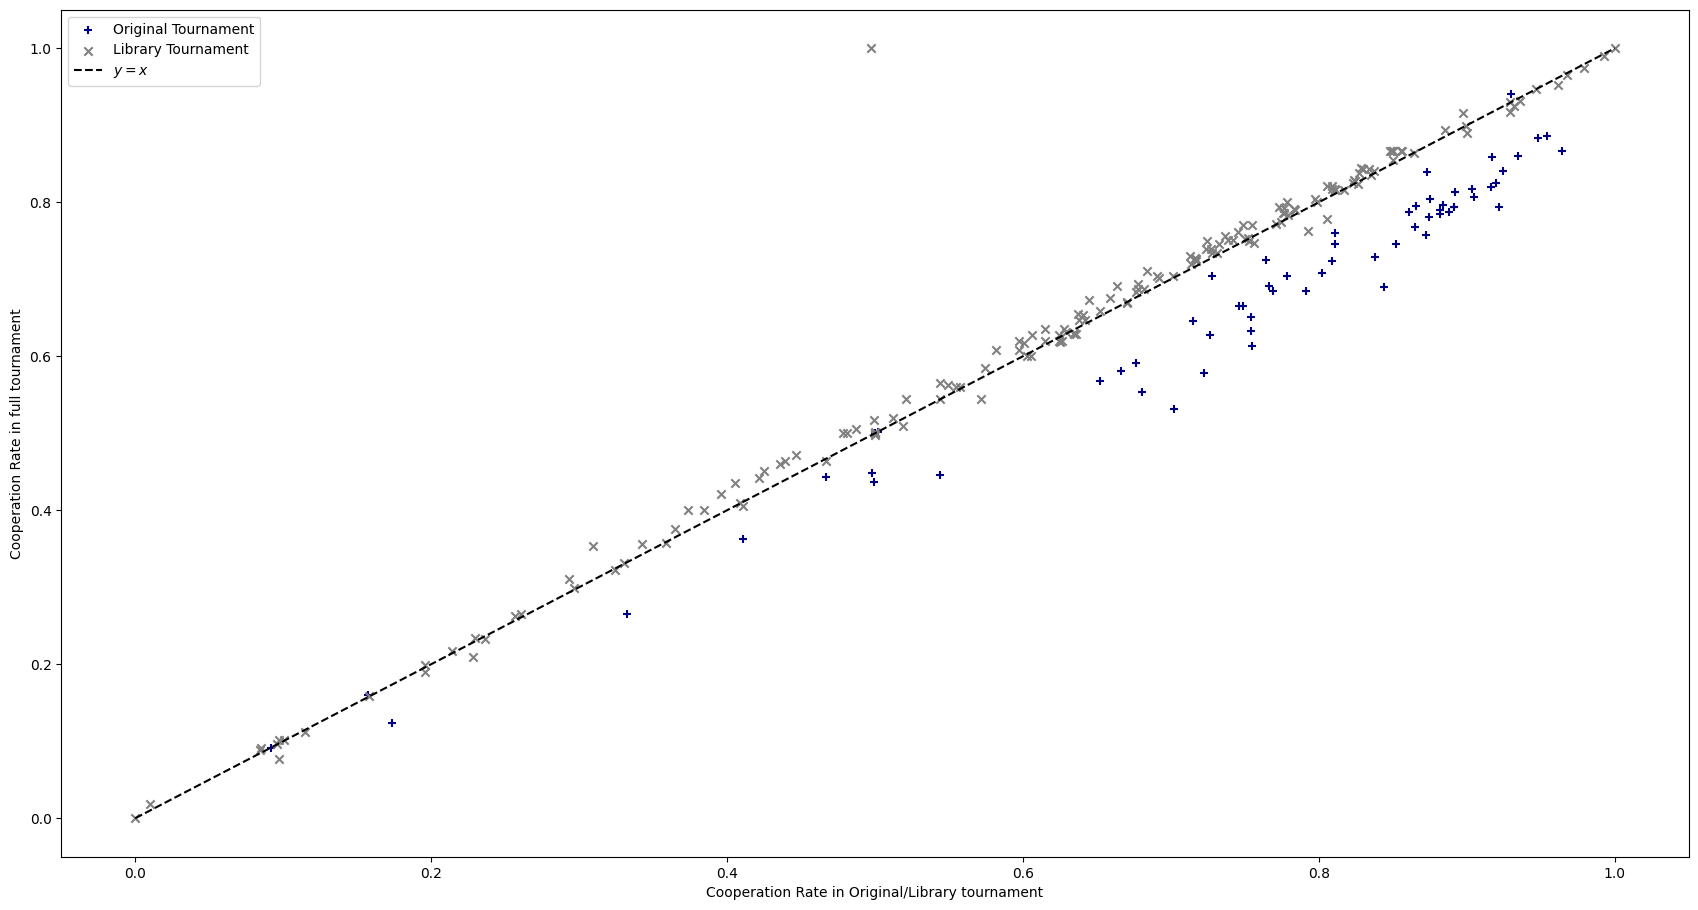

In [53]:
plt.figure(figsize=(21, 11))
plt.scatter(full_ranking_df["Original Mean Cooperation Rate"], full_ranking_df["Mean Cooperation Rate"], label="Original Tournament", marker="+", color="navy")
plt.scatter(full_ranking_df["Library Mean Cooperation Rate"], full_ranking_df["Mean Cooperation Rate"], label="Library Tournament", marker="x", color="grey")
plt.plot((0, 1), (0, 1), linestyle="dashed", color="black", label="$y=x$")
plt.ylabel("Cooperation Rate in full tournament")
plt.xlabel("Cooperation Rate in Original/Library tournament")
plt.legend()
plt.savefig("../assets/relative_cooperation_rates.pdf", transparent=True);

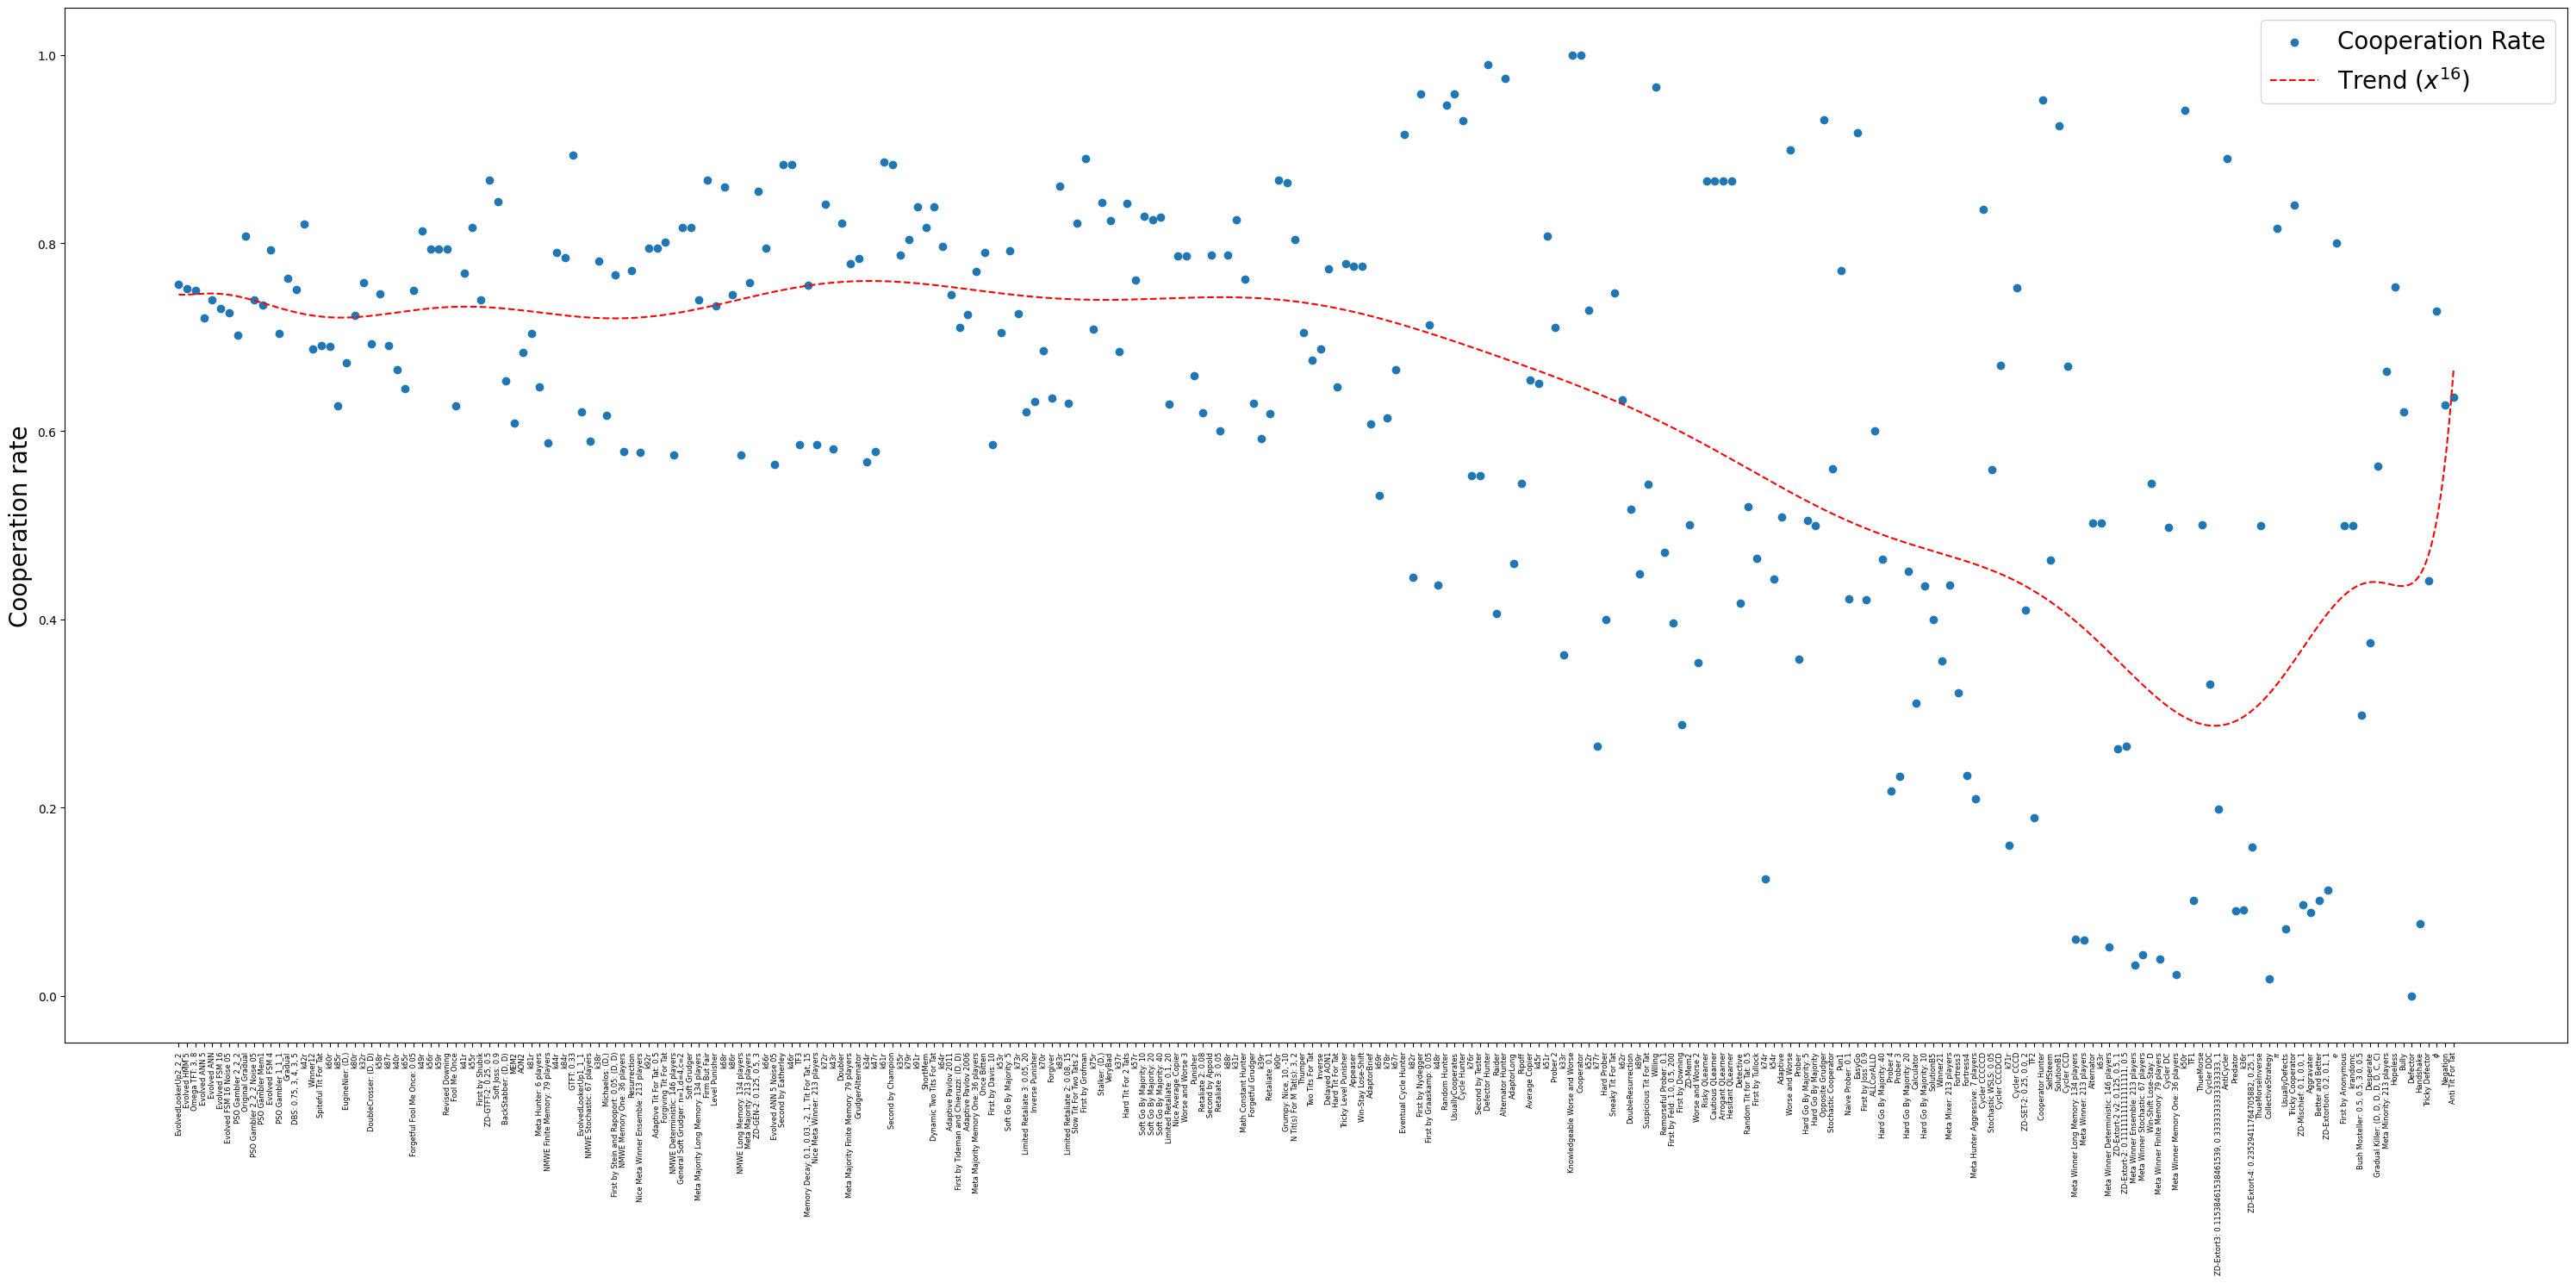

In [54]:
plt.subplots(1, figsize=(30, 15))

plt.scatter(full_ranking_df["Rank"], full_ranking_df["Mean Cooperation Rate"], label="Cooperation Rate")

degree = 16
z = np.polyfit(full_ranking_df["Rank"], full_ranking_df["Mean Cooperation Rate"], degree)
p = np.poly1d(z)
x = np.linspace(1, full_ranking_df["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend ($x^{{{}}}$)".format(degree))

plt.ylabel("Cooperation rate", fontsize=20)
plt.xticks(range(1, len(full_ranking_df.index) + 1), full_ranking_df.index, rotation=90, fontsize=6)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("../assets/full_tournament_cooperation_rate_versus_rank.pdf", transparent=True)

## Adding another strategy from the library

In [55]:
full_tournament_player_index = pd.read_csv(
    f"{full_tournament_data_path}/players.index",
    names=("Name",),
)

fortran_player_index = pd.read_csv(
    f"{original_tournament_data_path}/players.index",
    names=("Name",),
)
full_tournament_payoff_matrix, repetitions = read_payoff_matrix(
    full_tournament_data_path.glob("*payoff_matrix.gz")
)

In [56]:
def get_indices_of_players(player_names, player_index):
    """
    Returns the indices of the players in `player_names` from `player_index`
    """
    indices = []
    for player in player_names:
        indices.append(list(player_index).index(player))
    return indices

In [57]:
indices = get_indices_of_players(
    player_names=fortran_player_index["Name"], 
    player_index=full_tournament_player_index["Name"],
)

In [58]:
def get_results_of_sub_tournament(
    player_names, 
    payoff_matrix, 
    player_index, 
    characteristics=characteristics,
):
    player_indices = get_indices_of_players(player_names, player_index)
    player_index_mesh = np.ix_(player_indices, player_indices)
    payoff_sub_matrix = payoff_matrix[player_index_mesh]
    mean_payoffs = np.mean(payoff_sub_matrix, axis=1)
    median_payoffs = np.median(payoff_sub_matrix, axis=1)
    df = pd.DataFrame(
        {
            "Name": player_names,
            "Mean payoff": mean_payoffs,
            "Median payoff": median_payoffs,
        }
    )
    df["Rank"] = df["Mean payoff"].rank(ascending=False)
    original_ranks = []
    for name in df["Name"]:
        try:
            original_rank = characteristics[name]['original_rank']
        except KeyError:
            original_rank = None
        original_ranks.append(original_rank)
    df["Original Rank"] = original_ranks
    return df.sort_values("Rank")

Now let us read in a data file with a summary of the outcome of adding subsets of strategies to Axelrod's tournament:

In [59]:
df = pd.read_csv("./data/extra_player/main.csv")
df

Name  Mean payoff  Median payoff  \
0                                    ALLCorALLD     2.119473       2.227812   
1                                          AON2     2.634555       3.000000   
2                          Adaptive Pavlov 2006     2.745572       3.000000   
3                          Adaptive Pavlov 2011     2.722915       3.000000   
4                                      Adaptive     1.932526       1.854349   
...                                         ...          ...            ...   
4543028             NMWE Memory One: 36 players     2.611394       3.000000   
4543029           Nice Meta Winner: 213 players     2.603638       3.000000   
4543030             NMWE Stochastic: 67 players     2.644957       3.000000   
4543031  Nice Meta Winner Ensemble: 213 players     2.619013       3.000000   
4543032           Nice Meta Winner: 213 players     2.603638       3.000000   

         Rank  Original Rank  number of new strategies  tournament id Winner  
0        58.0            NaN                         1              1   k92r  
1        49.0            NaN                         1              2   k92r  
2        17.0            NaN                         1              3   k92r  
3        23.0            NaN                         1              4   k92r  
4        61.0            NaN                         1              5   k92r  
...       ...            ...                       ...            ...    ...  
4543028  48.0            NaN                         3        1521728   k92r  
4543029  50.0            NaN                         3        1521728   k92r  
4543030  45.0            NaN                         3        1521729   k92r  
4543031  48.0            NaN                         3        1521729   k92r  
4543032  50.0            NaN                         3        1521729   k92r  

[4543033 rows x 8 columns]

First let us look at the top ranking single strategies added to the tournament:

In [123]:
single_strategy_ranking_df = df[df["number of new strategies"] == 1].sort_values("Rank")
single_strategy_ranking_df = single_strategy_ranking_df[["Name", "Mean payoff", "Rank", "Winner"]]
single_strategy_ranking_df = single_strategy_ranking_df.rename(columns={"Mean payoff": "Mean Score"})
single_strategy_ranking_df["Rank"] = single_strategy_ranking_df["Rank"].astype(int)
single_strategy_ranking_df = single_strategy_ranking_df.set_index("Name")

with open("../assets/original_tournament_with_extra_strategy_summary.tex", "w") as f:
    f.write(single_strategy_ranking_df.head(20).to_latex(float_format="%.3f").replace("_", "\_"))

<>:8: SyntaxWarning: invalid escape sequence '\_'
<>:8: SyntaxWarning: invalid escape sequence '\_'
/var/folders/2p/gzkw2x1n7vb7g7p_c4d43vbw0000gp/T/ipykernel_89642/3432215647.py:8: SyntaxWarning: invalid escape sequence '\_'
  f.write(single_strategy_ranking_df.head(20).to_latex(float_format="%.3f").replace("_", "\_"))


In [125]:
alternate_winners_proportion_df = pd.DataFrame()
for i in range(1, 3 + 1):
    alternate_winners_proportion_df = alternate_winners_proportion_df.join(
        pd.DataFrame(df[(df["number of new strategies"] == i)]["Winner"].value_counts(normalize=True)),
        how="outer",
    )
    alternate_winners_proportion_df = alternate_winners_proportion_df.rename(columns={"proportion": f"{i} New (N = {int(sum(df["number of new strategies"] == i) / i): ,})"})

In [127]:
with open("../assets/alternate_extra_strategy_tournament_winner_proportion.tex", "w") as f:
    f.write(alternate_winners_proportion_df.to_latex(float_format="%.6f").replace("_", "\_"))

<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\_'
/var/folders/2p/gzkw2x1n7vb7g7p_c4d43vbw0000gp/T/ipykernel_89642/3326427293.py:2: SyntaxWarning: invalid escape sequence '\_'
  f.write(alternate_winners_proportion_df.to_latex(float_format="%.6f").replace("_", "\_"))


## Stewart and Plotkin Strategies

In [237]:
stewart_and_plotkin_players = [axl.Cooperator(),
                               axl.Defector(),
                               axl.ZDExtort2(),
                               axl.HardGoByMajority(),
                               axl.FirstByJoss(),
                               axl.HardTitForTat(),
                               axl.HardTitFor2Tats(),
                               axl.TitForTat(),
                               axl.Grudger(),
                               axl.GTFT(),
                               axl.TitFor2Tats(),
                               axl.WinStayLoseShift(),
                               axl.Random(),
                               axl.ZDGTFT2()]
stewart_and_plotkin_player_names = [p.__repr__() for p in stewart_and_plotkin_players]
stewart_and_plotkin_player_names

['Cooperator',
 'Defector',
 'ZD-Extort-2: 0.1111111111111111, 0.5',
 'Hard Go By Majority',
 'First by Joss: 0.9',
 'Hard Tit For Tat',
 'Hard Tit For 2 Tats',
 'Tit For Tat',
 'Grudger',
 'GTFT: 0.33',
 'Tit For 2 Tats',
 'Win-Stay Lose-Shift',
 'Random: 0.5',
 'ZD-GTFT-2: 0.25, 0.5']

In [238]:
implemented_strategies = {characteristics[name]['axelrod-python_class'] : name for name in fortran_player_index["Name"]}
player_names = sorted(list(fortran_player_index["Name"]) + [name for name in stewart_and_plotkin_player_names if name not in implemented_strategies])

In [252]:
sp_scores_df = get_results_of_sub_tournament(
    player_names=player_names, 
    payoff_matrix=full_tournament_payoff_matrix, 
    player_index=full_tournament_player_index["Name"], 
    characteristics=characteristics,
).rename(columns={"Mean payoff": "Mean Score"}).set_index("Name")
sp_cooperation_df = get_results_of_sub_tournament(
    player_names=player_names, 
    payoff_matrix=full_tournament_cooperation_rate_matrix, 
    player_index=full_tournament_player_index["Name"], 
    characteristics=characteristics,
).rename(columns={"Mean payoff": "Mean Cooperation Rate", "Median payoff": "Median Cooperation Rate"}).set_index("Name")
sp_scores_df = sp_scores_df.join(ranking_df[["Mean Cooperation Rate"]])
sp_scores_df = sp_scores_df.rename(columns={"Mean Cooperation Rate": "Original Mean Cooperation Rate"})
sp_scores = sp_scores_df.join(sp_cooperation_df["Mean Cooperation Rate"])
stewart_and_plotkin_player_names_with_implemented_names = [(name if (name not in implemented_strategies) else implemented_strategies[name]) for name in stewart_and_plotkin_player_names]
sp_only_cooperation_df = get_results_of_sub_tournament(
    player_names=stewart_and_plotkin_player_names_with_implemented_names, 
    payoff_matrix=full_tournament_cooperation_rate_matrix, 
    player_index=full_tournament_player_index["Name"], 
    characteristics=characteristics,
)
sp_only_cooperation_df = sp_only_cooperation_df.rename(columns={"Mean payoff": "S. and P. Mean Cooperation Rate", "Median payoff": "Median Cooperation Rate"}).set_index("Name")
sp_scores = sp_scores.join(sp_only_cooperation_df[["S. and P. Mean Cooperation Rate"]])
sp_ranking_df = sp_scores[["Mean Score", "Rank", "Mean Cooperation Rate", "Original Mean Cooperation Rate", "S. and P. Mean Cooperation Rate"]].round(4)
sp_ranking_df["Rank"] = sp_ranking_df["Rank"].astype(pd.Int64Dtype())

In [253]:
with open("../assets/sp_tournament_rankings.tex", "w") as f:
    f.write(sp_ranking_df.head(25).to_latex(float_format="%.3f"))

In [254]:
with open("../assets/sp_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write(f"{sp_ranking_df['Mean Cooperation Rate'].mean():.03}")

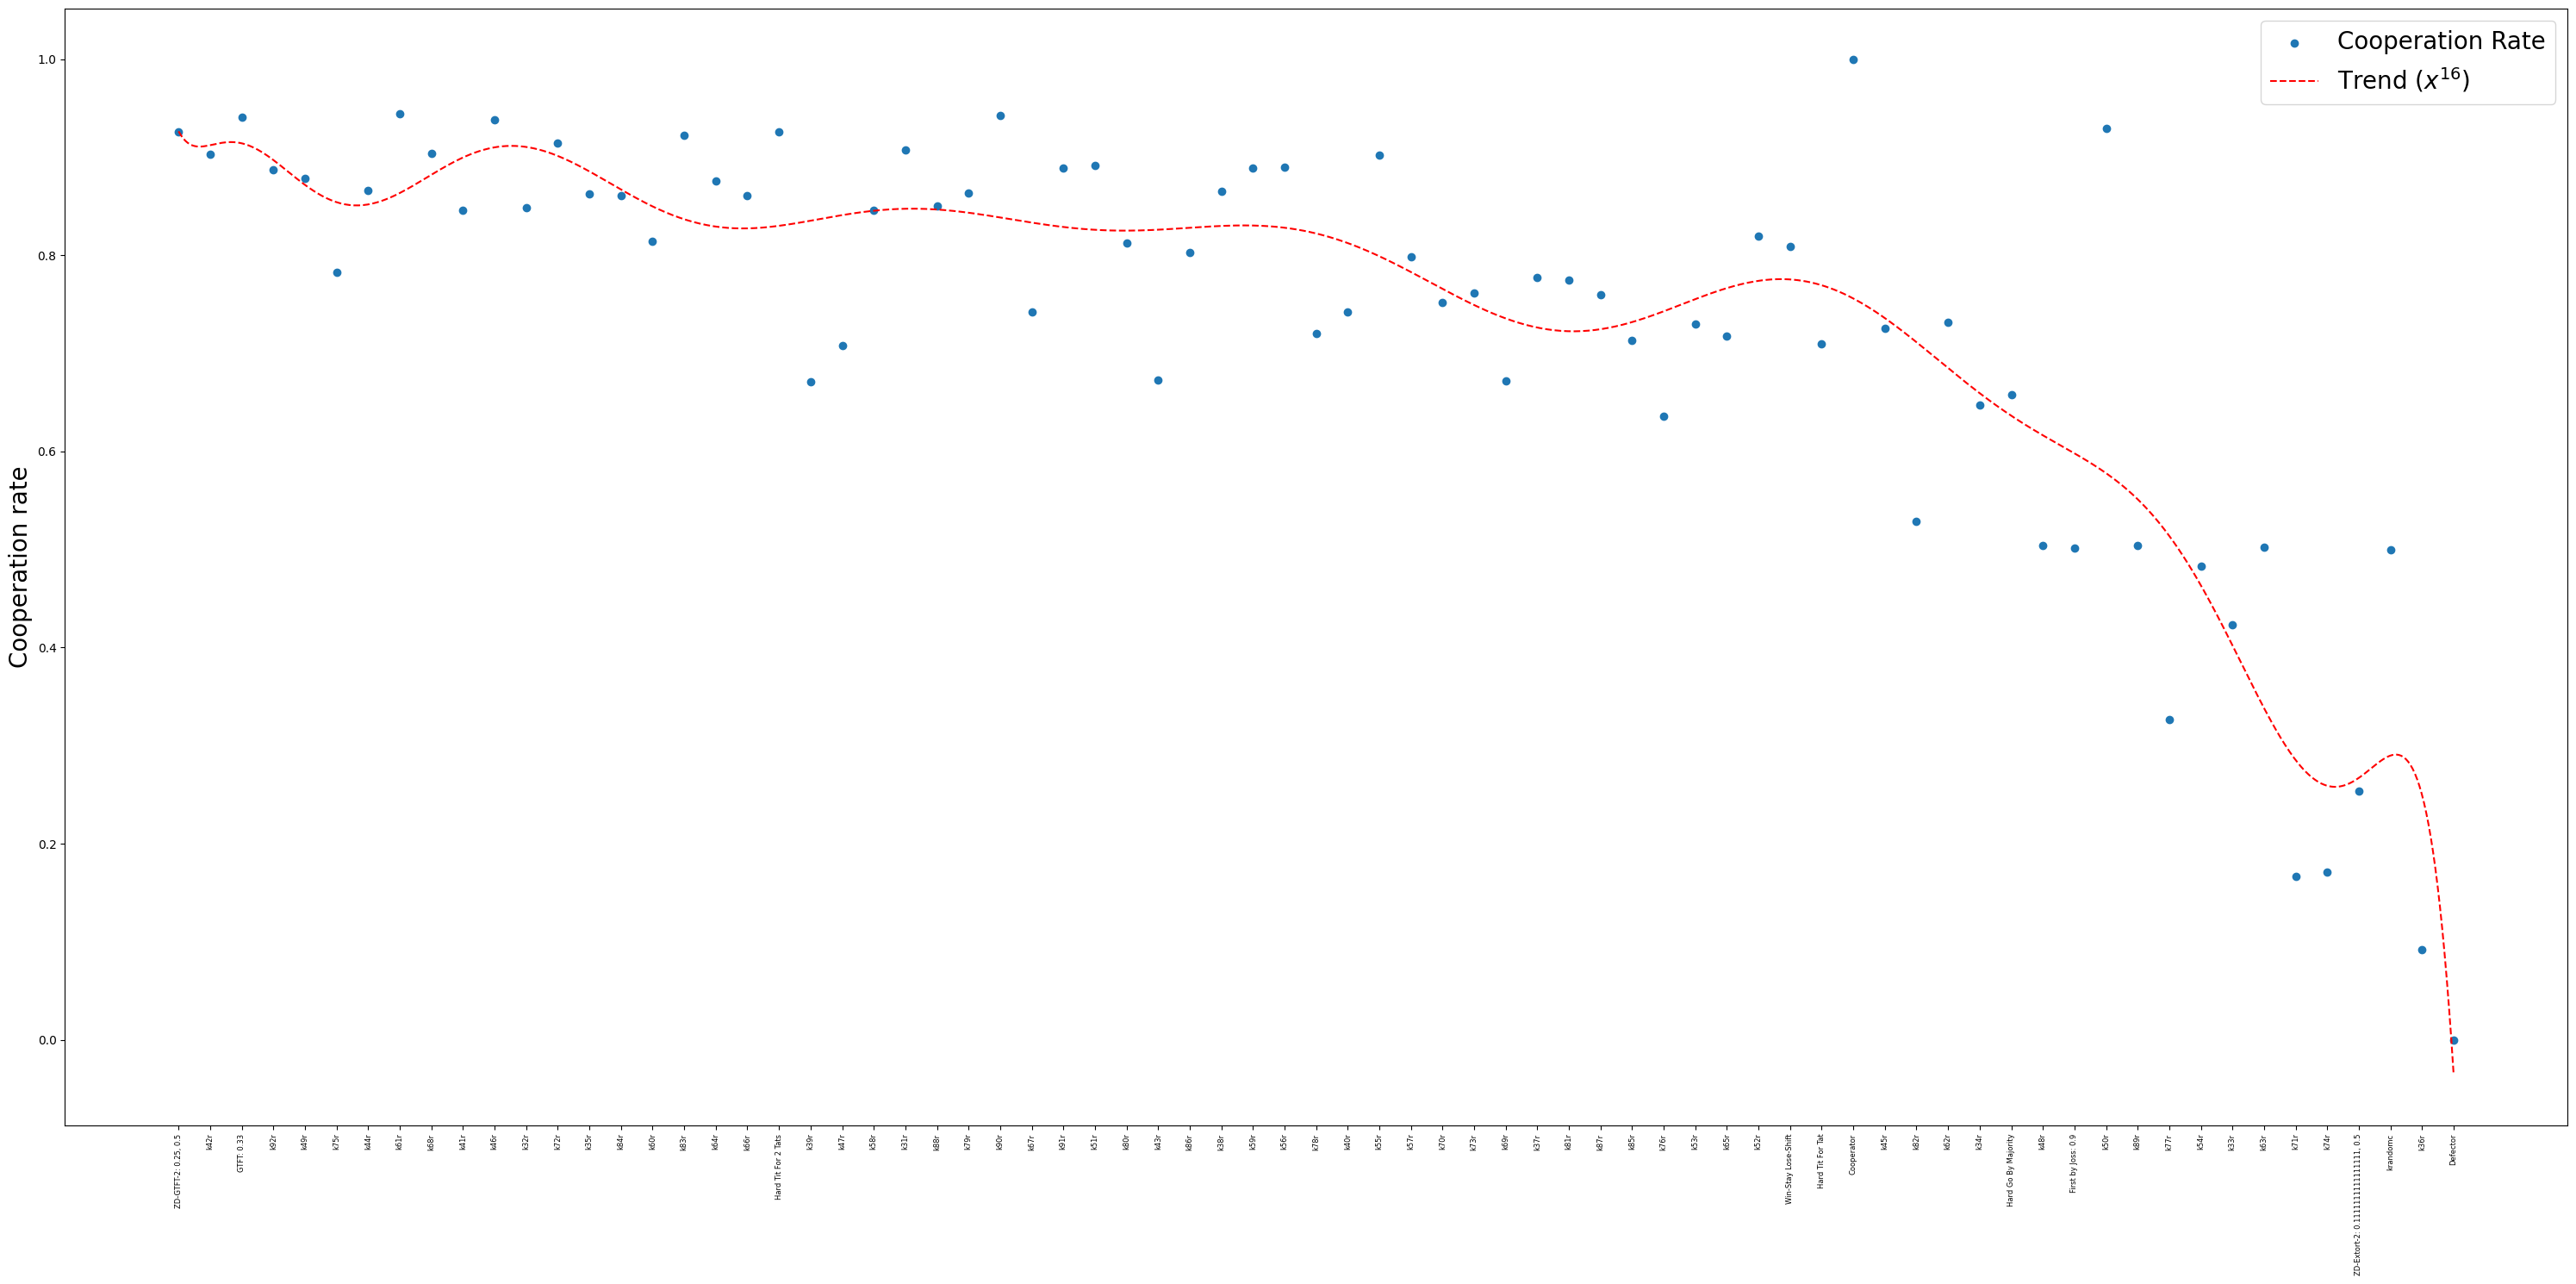

In [255]:
plt.subplots(1, figsize=(30, 15))

plt.scatter(sp_ranking_df["Rank"], sp_ranking_df["Mean Cooperation Rate"], label="Cooperation Rate")

degree = 16
z = np.polyfit(sp_ranking_df["Rank"], sp_ranking_df["Mean Cooperation Rate"], degree)
p = np.poly1d(z)
x = np.linspace(1, sp_ranking_df["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend ($x^{{{}}}$)".format(degree))

plt.ylabel("Cooperation rate", fontsize=20)
plt.xticks(range(1, len(sp_ranking_df.index) + 1), sp_ranking_df.index, rotation=90, fontsize=6)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("../assets/sp_tournament_cooperation_rate_versus_rank.pdf", transparent=True)

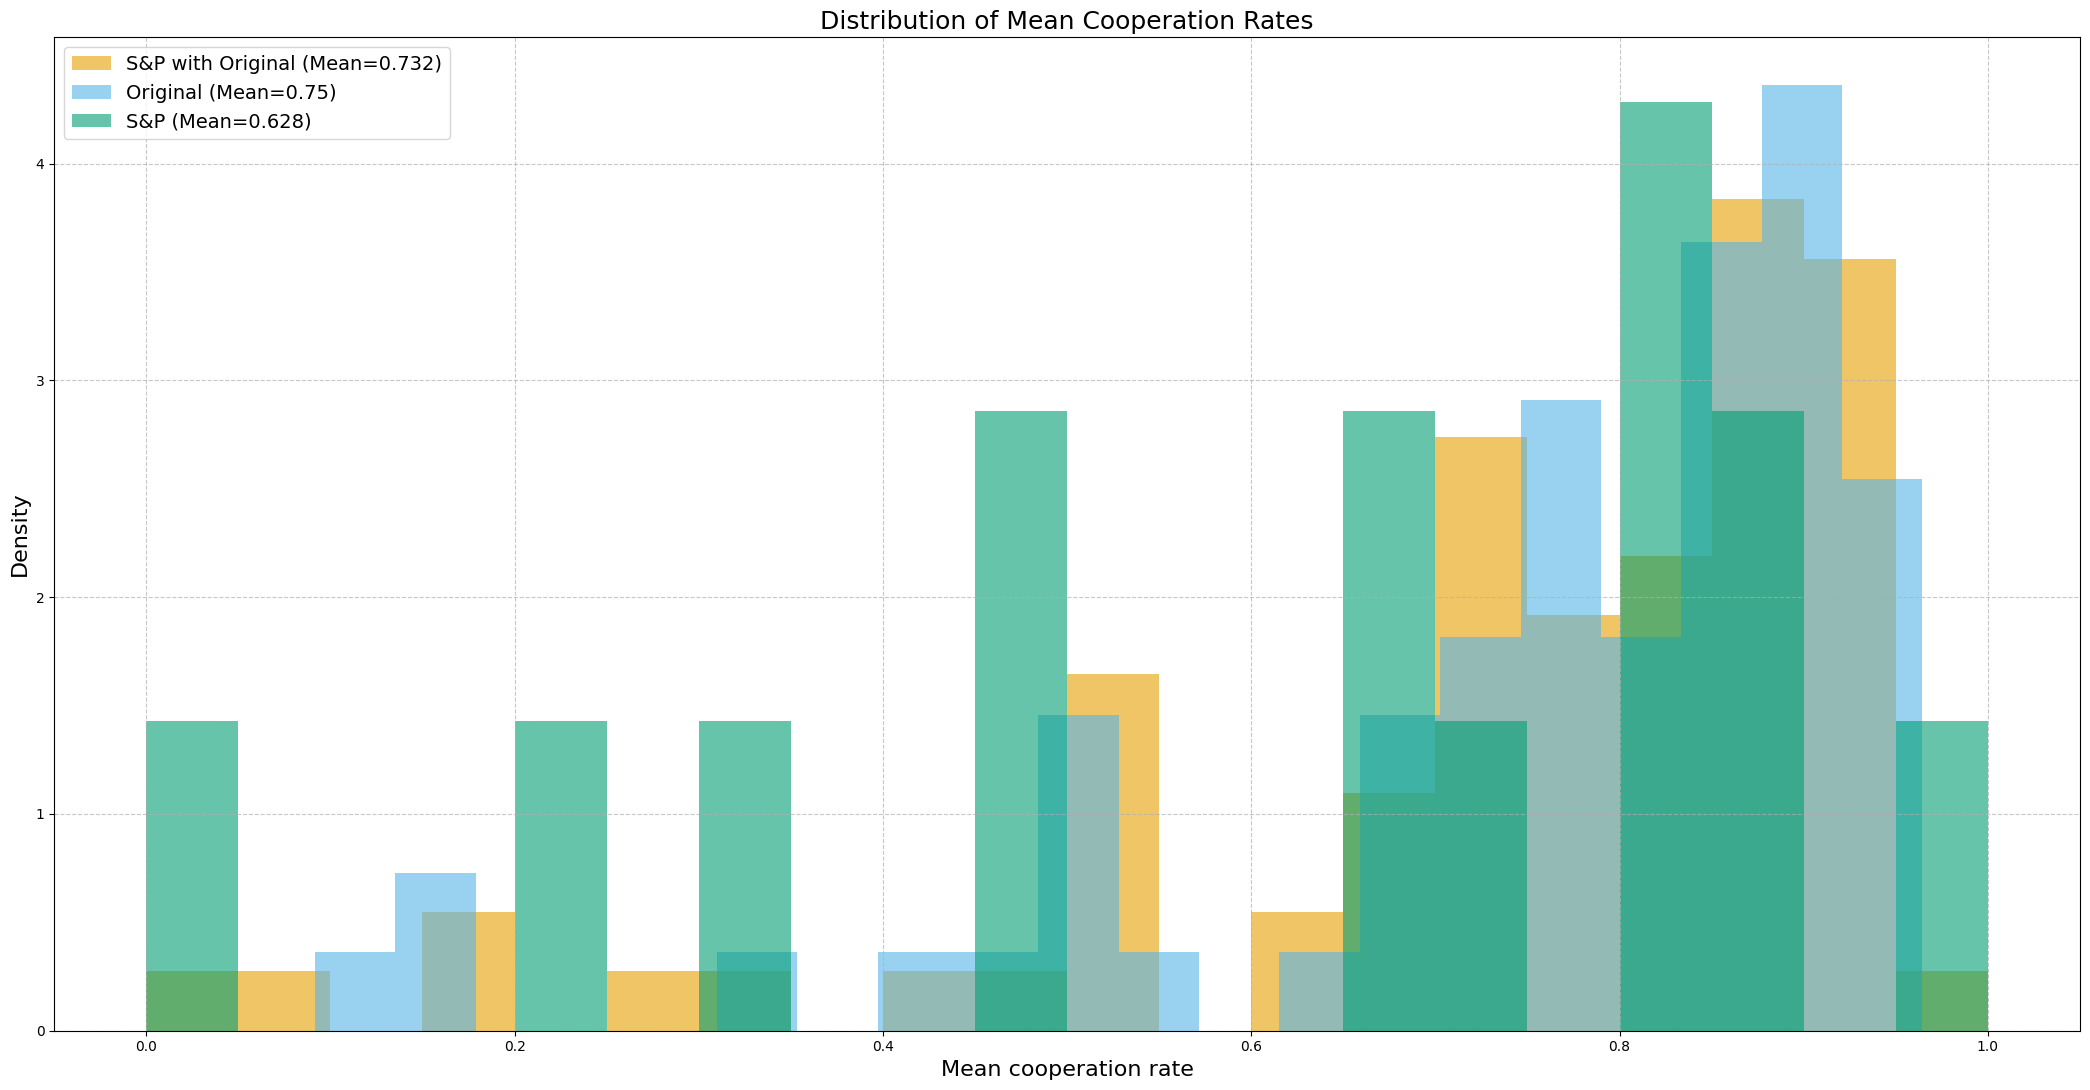

In [256]:
# Color blind friendly colors from Color Universal Design (CUD)
colors = ["#E69F00", "#56B4E9", "#009E73"]

plt.figure(figsize=(21, 11))

plt.hist(
    sp_ranking_df["Mean Cooperation Rate"], 
    bins=20, alpha=0.6, label=f"S&P with Original (Mean={sp_ranking_df['Mean Cooperation Rate'].mean():.03})", color=colors[0],
    density=True,
)
plt.hist(
    full_ranking_df["Original Mean Cooperation Rate"], 
    bins=20, alpha=0.6, label=f"Original (Mean={sp_ranking_df['Original Mean Cooperation Rate'].mean():.03})", color=colors[1],
    density=True,
)
plt.hist(
    sp_ranking_df["S. and P. Mean Cooperation Rate"], 
    bins=20, alpha=0.6, label=f"S&P (Mean={sp_ranking_df['S. and P. Mean Cooperation Rate'].mean():.03})", color=colors[2],
    density=True,
)

plt.xlabel("Mean cooperation rate", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Distribution of Mean Cooperation Rates", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("../assets/sp_tournament_cooperation_rates.pdf", transparent=True)

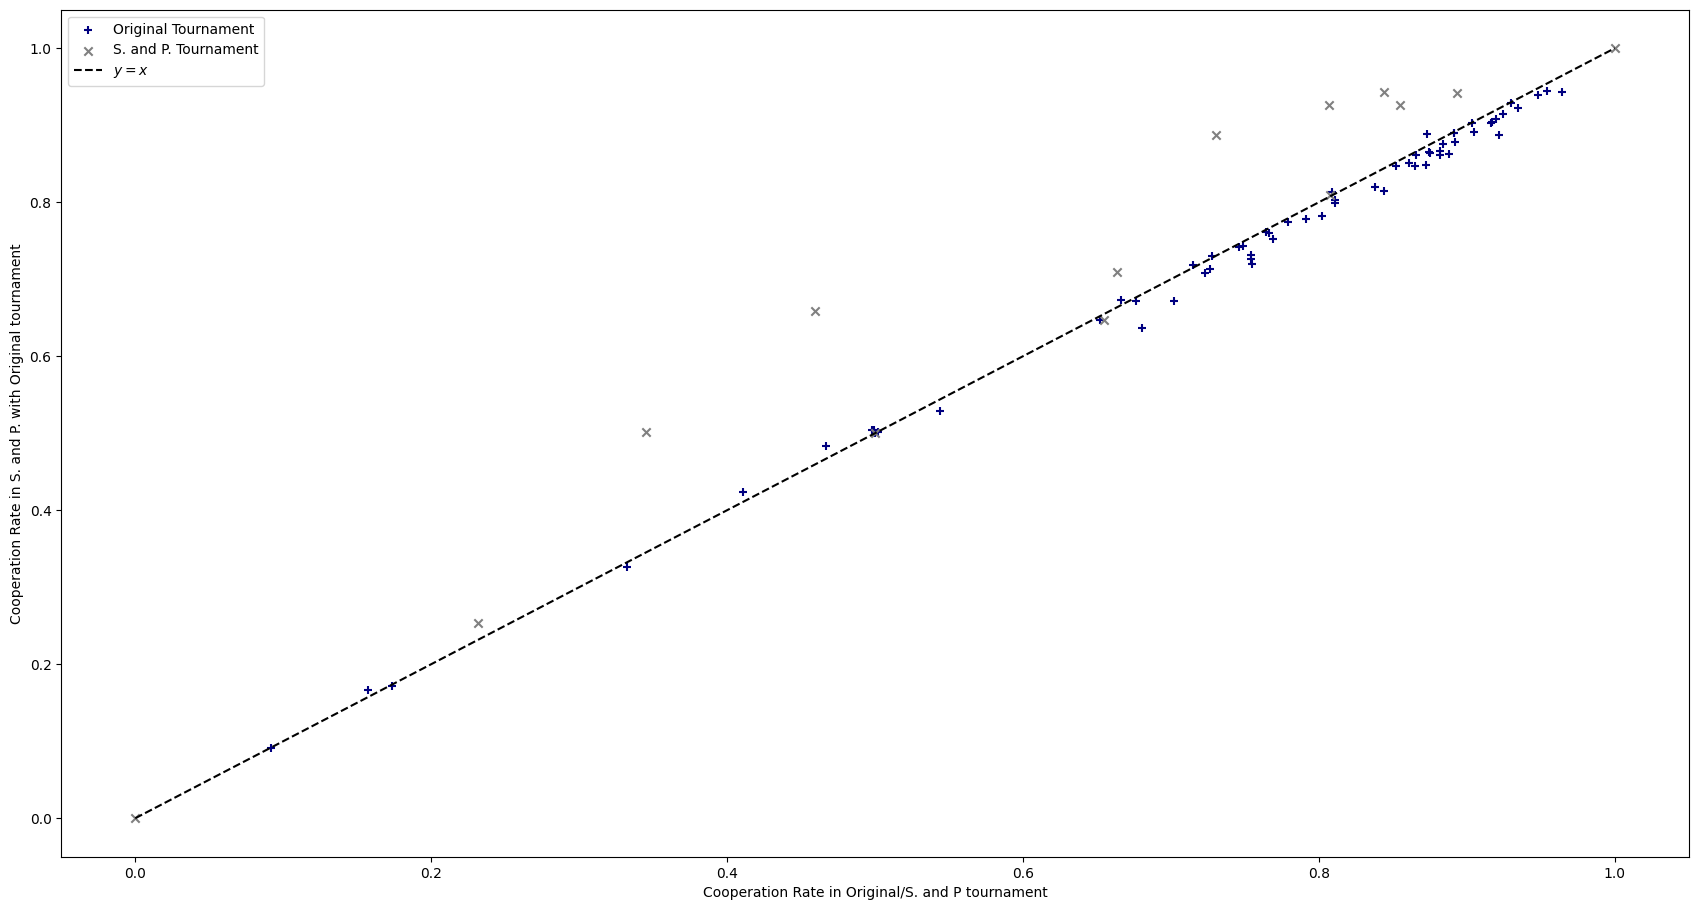

In [257]:
plt.figure(figsize=(21, 11))
plt.scatter(sp_ranking_df["Original Mean Cooperation Rate"], sp_ranking_df["Mean Cooperation Rate"], label="Original Tournament", marker="+", color="navy")
plt.scatter(sp_ranking_df["S. and P. Mean Cooperation Rate"], sp_ranking_df["Mean Cooperation Rate"], label="S. and P. Tournament", marker="x", color="grey")
plt.plot((0, 1), (0, 1), linestyle="dashed", color="black", label="$y=x$")
plt.ylabel("Cooperation Rate in S. and P. with Original tournament")
plt.xlabel("Cooperation Rate in Original/S. and P tournament")
plt.legend()
plt.savefig("../assets/sp_relative_cooperation_rates.pdf", transparent=True);